In [ ]:
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch import nn
import math
import torch.nn.functional as F
from tqdm.notebook import tqdm
import pandas as pd
from datetime import datetime
from cimport numpy as np
ollections import Counter
import time

import yfinance as yf
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import SimpleRNN
from keras.layers import Dropout
from keras.layers import GRU, Bidirectional
from keras.optimizers import SGD
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.patches as mpatches
import matplotlib.dates as mdates
from datetime import datetime, timedelta

In [ ]:
import torch

# Check if GPU is available
if torch.cuda.is_available():
    print("CUDA is available!")
    print("Device:", torch.cuda.get_device_name(0))
    print("Current device:", torch.cuda.current_device())
else:
    print("CUDA is not available.")


CUDA is not available.


In [ ]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 1.) Dataset Loading and Pre-processing

## 1. 1) Store dataset
The store dataset contains about 2541 entries. These entries. This huge dataset has been reduced to 413 entries.

1.   A mapping of the **STORE_NUMBER** value present in the store dataset is made to the **STORE_NUMBER** value present in sales dataset.
2.   Stores having closing dates before opening dates are considered invalid

Columns containing similar information are dropped. Final columns are:

1.   Store Related

>1. STORE_NUMBER
>2. STORE_NAME
>3. STORE_TYPE_NAME
>4. STORE_CONCEPT_NAME

2.   Opening & Closing Dates

>1. OPEN_DATE

3. City- State- Region

>1. CITY_NAME
>2. STATE_NAME
>3. DMA_ID
>4. DMA_NAME
>5. REGION_ID
>6. REGION_NAME
>7. AREA_REGION
>8. TIME_ZONE_NAME

4. Store Status

>1. STORE_STATUS
>2. STORE_FUNCTIONALITY_STATUS

5.  Go Live Dates

>1. STORE_LIVE_DATE
>2. DISPATCH_GO_LIVE_DATE
>3. DOOR_DASH_GO_LIVE_DATE
>4. DOOR_DASH_MARKUP_GO_LIVE_DATE
>5. UBER_EATS_MARKUP_DATE

Final Size : (413, 22)



In [ ]:
#csv to dataframe
store_file_name ='/content/drive/MyDrive/Trilytics 2024 Case study Data/store.csv'
store_data_frame = pd.read_csv(store_file_name)
print(store_data_frame.nunique())
print(store_data_frame.shape)

STORE_KEY                        2452
STORE_NUMBER                     2452
ROW_EFFECTIVE_TIMESTAMP           114
ROW_EXPIRATION_TIMESTAMP          113
STORE_NAME                       2449
STORE_TYPE_CODE                     2
STORE_TYPE_NAME                     2
OPEN_DATE                        1703
CLOSE_DATE                        152
CITY_NAME                        1538
STATE_CODE                         47
STATE_NAME                         47
COUNTRY_CODE                        1
COUNTRY_NAME                        0
TIME_ZONE_NAME                      8
DMA_ID                            160
DMA_NAME                          161
ROYALTY_RATE                        0
STORE_STATUS                        3
REGION_ID                           4
REGION_NAME                         5
PRIOR_STORE_NUMBER                 13
STORE_LIVE_DATE                  1706
STORE_FUNCTIONAL_STATUS             7
GLOBAL_REGION_NAME                  1
GLOBAL_REGION_STORE_TYPE_NAME       2
AREA_REGION 

In [ ]:
# Extract unique store numbers from sales dataset and map it to store dataset. Intersection of
# both will be valid stores in store dataset

sales_df = pd.read_csv('/content/drive/MyDrive/Trilytics 2024 Case study Data/sales.csv')

unique_stores = sales_df['STORE_NUMBER'].unique()
store_data_frame = store_data_frame[store_data_frame['STORE_NUMBER'].isin(unique_stores)]
print(len(unique_stores))
store_data_frame.shape

477


(419, 34)

In [ ]:
try:
  store_data_frame['OPEN_DATE'] = pd.to_datetime(store_data_frame['OPEN_DATE']).dt.strftime('%d-%m-%Y')
  # store_data_frame['CLOSE_DATE'] = pd.to_datetime(store_data_frame['CLOSE_DATE']).dt.strftime('%d-%m-%Y')
  store_data_frame['STORE_LIVE_DATE'] = pd.to_datetime(store_data_frame['STORE_LIVE_DATE']).dt.strftime('%d-%m-%Y')
  store_data_frame['DISPATCH_GO_LIVE_DATE'] = pd.to_datetime(store_data_frame['DISPATCH_GO_LIVE_DATE']).dt.strftime('%d-%m-%Y')
  store_data_frame['DOOR_DASH_GO_LIVE_DATE'] = pd.to_datetime(store_data_frame['DOOR_DASH_GO_LIVE_DATE']).dt.strftime('%d-%m-%Y')
  store_data_frame['DOOR_DASH_MARKUP_GO_LIVE_DATE'] = pd.to_datetime(store_data_frame['DOOR_DASH_MARKUP_GO_LIVE_DATE']).dt.strftime('%d-%m-%Y')
  store_data_frame['UBER_EATS_MARKUP_DATE'] = pd.to_datetime(store_data_frame['UBER_EATS_MARKUP_DATE']).dt.strftime('%d-%m-%Y')
except ValueError as e:
  print(e)
store_data_frame.shape

(419, 34)

In [ ]:
# for index, row in store_data_frame.iterrows():
#   open = time.strptime(row['OPEN_DATE'], "%d-%m-%Y")
#   close = time.strptime(row['CLOSE_DATE'], "%d-%m-%Y")
#   if open < close:
#     # print(f"{open}   {close}")
#     store_data_frame = store_data_frame.drop(index)
# store_data_frame.shape

In [ ]:
#columns that are to be dropped
cols_to_drop = ['STORE_KEY','ROW_EFFECTIVE_TIMESTAMP','ROW_EXPIRATION_TIMESTAMP', 'CLOSE_DATE',
                'STORE_TYPE_CODE','STATE_CODE','COUNTRY_CODE','COUNTRY_NAME','ROYALTY_RATE',
                'GLOBAL_REGION_NAME','GLOBAL_REGION_STORE_TYPE_NAME','EDW_CREATE_TIMESTAMP',
                'EDW_MODIFY_TIMESTAMP','PRIOR_STORE_NUMBER']

store_data_frame = store_data_frame.drop(cols_to_drop, axis = 1)
# store_data_frame.to_csv('store_final.csv', index=False)
store_data_frame.shape

(419, 20)

In [ ]:
# Sorting of all entries based on increasing order of Store Number
store_data_frame =  store_data_frame.groupby("STORE_NUMBER").apply(lambda x: x.sort_values("STORE_NUMBER", ascending = True)).reset_index(drop=True)
store_data_frame.to_csv('/content/drive/MyDrive/Preprocessed dataset/Preprocessed dataset/store_final.csv', index=False)

In [ ]:
store_data_frame.head()

STORE_NUMBER STORE_NAME STORE_TYPE_NAME   OPEN_DATE    CITY_NAME  \
0             2        TX2       Franchise  09-05-1998       IRVING   
1             5        TX5       Franchise  22-08-1998       DALLAS   
2             7        TX7       Franchise  14-11-1998    ARLINGTON   
3            16       LA16       Franchise  29-04-2000  WEST MONROE   
4            27       TX27       Franchise  11-06-2001       DALLAS   

  STATE_NAME TIME_ZONE_NAME  DMA_ID          DMA_NAME STORE_STATUS  REGION_ID  \
0      Texas        Central   623.0  DALLAS-FT. WORTH       Active        1.0   
1      Texas        Central   623.0  DALLAS-FT. WORTH       Active        1.0   
2      Texas        Central   623.0  DALLAS-FT. WORTH     Inactive        1.0   
3  Louisiana        Central   628.0  MONROE-EL DORADO       Active        2.0   
4      Texas        Central   623.0  DALLAS-FT. WORTH       Active        1.0   

  REGION_NAME STORE_LIVE_DATE STORE_FUNCTIONAL_STATUS       AREA_REGION  \
0   Southwest      09-05-1998             Operational  DALLAS-FT. WORTH   
1   Southwest      22-08-1998             Operational  DALLAS-FT. WORTH   
2   Southwest      14-11-1998                Transfer  DALLAS-FT. WORTH   
3   Southeast      29-04-2000             Operational  MONROE-EL DORADO   
4   Southwest      11-06-2001             Operational  DALLAS-FT. WORTH   

  DISPATCH_GO_LIVE_DATE DOOR_DASH_GO_LIVE_DATE DOOR_DASH_MARKUP_GO_LIVE_DATE  \
0            17-04-2019             17-04-2019                    27-09-2020   
1            17-04-2019             17-04-2019                    27-09-2020   
2                   NaN                    NaN                    14-11-1998   
3            11-12-2019             11-12-2019                    27-09-2020   
4            17-04-2019             17-04-2019                    27-09-2020   

  STORE_CONCEPT_NAME UBER_EATS_MARKUP_DATE  
0           Original            20-07-2022  
1           Original            20-07-2022  
2                NaN            14-11-1998  
3           Original            20-07-2022  
4           Original            20-07-2022

## 1. 2) Sales dataset
The sales dataset is extracted into 2 separate datasets:


1.2.1.)   Store-wise dataset:

  *   For every store, the "TRANSACTION_FINAL_COUNT" and "NET_SALES_FINAL_USD_AMOUNT" are grouped for every 3 months which can be set with the parameter "*num_days_in_3_mon*" (which is 90 by default).
  *   The ordering of the months is specified in the newly added column called "MONTH_ORDER".
  *   Since the total number of records might not have in exact multiples of 90 days, we ignore the remaining days in the beginning.i.e., the oldest records are left out as it has least effect on the latest sales.
  *   The days in which the store is temporarily closed is included(counted) in the 3 month span based on the parameter "*include_closed_day*" (true by default).

  Final columns are:

    *   STORE_NUMBER
    *   OPEN_DATE : dd-mm-yyyy
    *   MONTH_ORDER : Higher the number, older the records are [0 is the latest for a particular store]
    *   START_DATE : Starting date of the 3 month period
    *   END_DATE : Ending date of the 3 month period
    *   TRANSACTION_FINAL_COUNT : Cumulative of the 3 month period
    *   NET_SALES_FINAL_USD_AMOUNT : Cumulative of the 3 month period

  Final size:
    (6926, 7)
---

1.2.2.)   3 Month-wise dataset:

  *   The individual stores are ignored. The "TRANSACTION_FINAL_COUNT" and "NET_SALES_FINAL_USD_AMOUNT" are grouped across all the stores for every 3 months which can be set with the parameter "*num_days_in_3_mon*" (which is 90 by default).
  *   The ordering of the months is specified in the newly added column called "MONTH_ORDER".
  *   The beginning and end dates of the 3 month period is included in the fields "START_DATE" and "END_DATE".

  Final columns are:

    *   MONTH_ORDER : Higher the number, older the records are [0 is the latest for a particular store]
    *   START_DATE : Starting date of the 3 month period
    *   END_DATE : Ending date of the 3 month period
    *   TRANSACTION_FINAL_COUNT : Cumulative of the 3 month period
    *   NET_SALES_FINAL_USD_AMOUNT : Cumulative of the 3 month period

  Final size:
    (19, 5)
---

Similar pre-processing is performed keeping the "*num_days_in_3_mon*" as 7 and 1 to achieve weekly and daily grouping respectively.


### 1.2.1) Store-wise dataset

In [ ]:
# Parameters:
num_days_in_3_mon = 90
num_days_in_3_mon = 7
num_days_in_3_mon = 1
include_closed_day = True

In [ ]:
# csv to dataframe
sales_file_name = "/content/drive/MyDrive/Trilytics 2024 Case study Data/sales.csv"
data_frame_sales = pd.read_csv(sales_file_name)
print(data_frame_sales.nunique())
print(data_frame_sales.shape)

STORE_KEY                              477
STORE_NUMBER                           477
OPEN_DATE                              453
BUSINESS_DATE_KEY                     1714
BUSINESS_DATE                         1714
TEMP_CLOSE_INDICATOR                     2
PROJECTION_INCLUDED_INDICATOR            2
BUSINESS_DATE_FISCAL_DAY_OF_YEAR       371
BUSINESS_DATE_FISCAL_YEAR                6
COMP_BUSINESS_DATE_FISCAL_YEAR           6
COMPARABLE_INDICATOR                     2
TRANSACTION_FINAL_COUNT               1057
NET_SALES_FINAL_USD_AMOUNT          426707
PY_TRANSACTION_FINAL_COUNT             859
PY_NET_SALES_FINAL_USD_AMOUNT       341734
dtype: int64
(632197, 15)


In [ ]:
def discard_end_storewise():
  # Convert all date values to dd-mm-yyyy format
  try:
    data_frame_sales['OPEN_DATE'] = pd.to_datetime(data_frame_sales['OPEN_DATE']).dt.strftime('%d-%m-%Y')
    data_frame_sales['BUSINESS_DATE'] = pd.to_datetime(data_frame_sales['BUSINESS_DATE']).dt.strftime('%d-%m-%Y')
  except:
    pass

  # data_frame_sales.sort_values('STORE_NUMBER',inplace=True)
  # data_frame_sales.sort_values('BUSINESS_DATE_KEY',inplace=True)

  # Group the records based on STORE_NUMBER and sort it in increasing order of BUSINESS_DATE_KEY
  data_frame_sales = data_frame_sales.groupby("STORE_NUMBER").apply(lambda x: x.sort_values("BUSINESS_DATE_KEY", ascending = True)).reset_index(drop=True)


  # For every store, group 3 month data
  new_data_frame_sales = []
  counter = 0
  prev_store = -1000
  start_date = ""
  end_date = ""
  month_order = 0
  trans_cumm = 0
  net_sales_cumm = 0
  discarded = 0
  unique_stores = 0
  for index, row in data_frame_sales.iterrows():
    if not include_closed_day:
      if row['TEMP_CLOSE_INDICATOR'] == 1:
        continue

    if prev_store != row['STORE_NUMBER']:
      discarded += counter
      unique_stores += 1
      counter = 0
      prev_store = row['STORE_NUMBER']
      start_date = row['BUSINESS_DATE']
      month_order = 0
      trans_cumm = 0
      net_sales_cumm = 0

    if counter == 0:
      prev_store = row['STORE_NUMBER']
      start_date = row['BUSINESS_DATE']
      trans_cumm = 0
      net_sales_cumm = 0

    counter += 1
    trans_cumm += row['TRANSACTION_FINAL_COUNT']
    net_sales_cumm += row['NET_SALES_FINAL_USD_AMOUNT']

    if counter % num_days_in_3_mon == 0:
      end_date = row['BUSINESS_DATE']
      entry = {
          'STORE_NUMBER': row['STORE_NUMBER'],
          'OPEN_DATE': row['OPEN_DATE'],
          'MONTH_ORDER': month_order,
          'START_DATE': start_date,
          'END_DATE': end_date,
          'TRANSACTION_FINAL_COUNT': trans_cumm,
          'NET_SALES_FINAL_USD_AMOUNT': net_sales_cumm
      }
      new_data_frame_sales.append(entry)
      trans_cumm = 0
      net_sales_cumm = 0
      month_order += 1
      counter = 0

  discarded += counter

  print(f"Total discarded records: {discarded}")
  print(f"Total unique stores: {unique_stores}")
  print(f"Total records in the processed dataset: {len(new_data_frame_sales)}")


  # new_frame = data_frame_sales[data_frame_sales["STORE_NUMBER"] == 2]

In [ ]:
# Convert all date values to dd-mm-yyyy format
try:
  data_frame_sales['OPEN_DATE'] = pd.to_datetime(data_frame_sales['OPEN_DATE']).dt.strftime('%d-%m-%Y')
  data_frame_sales['BUSINESS_DATE'] = pd.to_datetime(data_frame_sales['BUSINESS_DATE']).dt.strftime('%d-%m-%Y')
except:
  pass

# data_frame_sales.sort_values('STORE_NUMBER',inplace=True)
# data_frame_sales.sort_values('BUSINESS_DATE_KEY',inplace=True)

# Group the records based on STORE_NUMBER and sort it in increasing order of BUSINESS_DATE_KEY
data_frame_sales = data_frame_sales.groupby("STORE_NUMBER").apply(lambda x: x.sort_values("BUSINESS_DATE_KEY", ascending = False)).reset_index(drop=True)


# For every store, group 3 month data
new_data_frame_sales = []
counter = 0
prev_store = -1000
start_date = ""
end_date = ""
month_order = 0
trans_cumm = 0
net_sales_cumm = 0
discarded = 0
unique_stores = 0
for index, row in data_frame_sales.iterrows():
  if not include_closed_day:
    if row['TEMP_CLOSE_INDICATOR'] == 1:
      continue

  if prev_store != row['STORE_NUMBER']:
    discarded += counter
    unique_stores += 1
    counter = 0
    prev_store = row['STORE_NUMBER']
    end_date = row['BUSINESS_DATE']
    month_order = 0
    trans_cumm = 0
    net_sales_cumm = 0

  if counter == 0:
    prev_store = row['STORE_NUMBER']
    end_date = row['BUSINESS_DATE']
    trans_cumm = 0
    net_sales_cumm = 0

  counter += 1
  trans_cumm += row['TRANSACTION_FINAL_COUNT']
  net_sales_cumm += row['NET_SALES_FINAL_USD_AMOUNT']

  if counter % num_days_in_3_mon == 0:
    start_date = row['BUSINESS_DATE']
    entry = {
        'STORE_NUMBER': row['STORE_NUMBER'],
        'OPEN_DATE': row['OPEN_DATE'],
        'MONTH_ORDER': month_order,
        'START_DATE': start_date,
        'END_DATE': end_date,
        'TRANSACTION_FINAL_COUNT': trans_cumm,
        'NET_SALES_FINAL_USD_AMOUNT': net_sales_cumm
    }
    new_data_frame_sales.append(entry)
    trans_cumm = 0
    net_sales_cumm = 0
    month_order += 1
    counter = 0

discarded += counter
print(f"Total discarded records: {discarded}")
print(f"Total unique stores: {unique_stores}")
print(f"Total records in the processed dataset: {len(new_data_frame_sales)}")
# new_frame = data_frame_sales[data_frame_sales["STORE_NUMBER"] == 2]


new_data_frame_sales = pd.DataFrame(new_data_frame_sales)
new_data_frame_sales = new_data_frame_sales.groupby("STORE_NUMBER").apply(lambda x: x.sort_values("MONTH_ORDER", ascending = False)).reset_index(drop=True)
new_data_frame_sales.to_csv("sales_store_wise.csv", index=False)

Total discarded records: 0
Total unique stores: 477
Total records in the processed dataset: 632197


In [ ]:
new_data_frame_sales.head()

STORE_NUMBER   OPEN_DATE  MONTH_ORDER START_DATE   END_DATE  \
0             2  05-09-1998         1713  4/23/2019  4/23/2019   
1             2  05-09-1998         1712  4/24/2019  4/24/2019   
2             2  05-09-1998         1711  4/25/2019  4/25/2019   
3             2  05-09-1998         1710  4/26/2019  4/26/2019   
4             2  05-09-1998         1709  4/27/2019  4/27/2019   

   TRANSACTION_FINAL_COUNT  NET_SALES_FINAL_USD_AMOUNT  
0                      109                     1809.84  
1                       93                     1465.08  
2                      151                     2429.24  
3                      226                     4151.27  
4                      137                     2529.99

In [ ]:
new_data_frame_sales.shape

(632197, 7)

### 1.2.2) 3-month wise sales dataset:

In [ ]:
# Parameters:
num_days_in_3_mon = 90
num_days_in_3_mon = 1
include_closed_day = True

In [ ]:
# csv to dataframe
sales_file_name = "/content/drive/MyDrive/Trilytics 2024 Case study Data/sales.csv"
data_frame_sales = pd.read_csv(sales_file_name)
print(data_frame_sales.nunique())
print(data_frame_sales.shape)

STORE_KEY                              477
STORE_NUMBER                           477
OPEN_DATE                              453
BUSINESS_DATE_KEY                     1714
BUSINESS_DATE                         1714
TEMP_CLOSE_INDICATOR                     2
PROJECTION_INCLUDED_INDICATOR            2
BUSINESS_DATE_FISCAL_DAY_OF_YEAR       371
BUSINESS_DATE_FISCAL_YEAR                6
COMP_BUSINESS_DATE_FISCAL_YEAR           6
COMPARABLE_INDICATOR                     2
TRANSACTION_FINAL_COUNT               1057
NET_SALES_FINAL_USD_AMOUNT          426707
PY_TRANSACTION_FINAL_COUNT             859
PY_NET_SALES_FINAL_USD_AMOUNT       341734
dtype: int64
(632197, 15)


In [ ]:
# Convert all date values to dd-mm-yyyy format
try:
  data_frame_sales['OPEN_DATE'] = pd.to_datetime(data_frame_sales['OPEN_DATE']).dt.strftime('%d-%m-%Y')
  data_frame_sales['BUSINESS_DATE'] = pd.to_datetime(data_frame_sales['BUSINESS_DATE']).dt.strftime('%d-%m-%Y')
except:
  pass

data_frame_sales.sort_values('BUSINESS_DATE_KEY',inplace=True, ascending=False)

# For every store, group 3 month data
new_data_frame_sales_monthwise = []
counter = 0
prev_date =  0
start_date = ""
end_date = ""
month_order = 0
trans_cumm = 0
net_sales_cumm = 0
# discarded = 0

for index, row in data_frame_sales.iterrows():
  if not include_closed_day:
    if row['TEMP_CLOSE_INDICATOR'] == 1:
      continue
  if counter == 0:
    end_date = row['BUSINESS_DATE']

  elif (prev_date != row['BUSINESS_DATE_KEY']) and (counter % num_days_in_3_mon == 0):
    date_string = f'{prev_date}'
    # date_object = datetime.strptime(date_string, '%Y%m%d')
    # formatted_date = date_object.strftime('%d-%m-%Y')
    # start_date = formatted_date
    year = date_string[:4]
    month = date_string[4:6]
    day = date_string[6:]
    start_date = day + "-" + month + "-" + year
    entry = {
        'MONTH_ORDER': month_order,
        'START_DATE': start_date,
        'END_DATE': end_date,
        'TRANSACTION_FINAL_COUNT': trans_cumm,
        'NET_SALES_FINAL_USD_AMOUNT': net_sales_cumm
    }
    print(entry)
    new_data_frame_sales_monthwise.append(entry)
    trans_cumm = 0
    net_sales_cumm = 0
    month_order += 1
    counter = 0
    end_date = row['BUSINESS_DATE']

  if prev_date != row['BUSINESS_DATE_KEY']:
    counter += 1

  # if counter == 0:
  #   prev_date = row['BUSINESS_DATE_KEY']
  #   end_date = row['BUSINESS_DATE']
  #   trans_cumm = 0
  #   net_sales_cumm = 0

  prev_date = row['BUSINESS_DATE_KEY']
  trans_cumm += row['TRANSACTION_FINAL_COUNT']
  net_sales_cumm += row['NET_SALES_FINAL_USD_AMOUNT']


discarded += counter
print(f"Total discarded records: {counter}")
print(f"Total records in the processed dataset: {len(new_data_frame_sales_monthwise)}")
# new_frame = data_frame_sales[data_frame_sales["STORE_NUMBER"] == 2]

new_data_frame_sales_monthwise = pd.DataFrame(new_data_frame_sales_monthwise)
new_data_frame_sales_monthwise.sort_values('MONTH_ORDER',inplace=True, ascending=False)
new_data_frame_sales_monthwise.to_csv("sales_month_wise.csv", index=False)

{'MONTH_ORDER': 0, 'START_DATE': '31-12-2023', 'END_DATE': '12/31/2023', 'TRANSACTION_FINAL_COUNT': 103230, 'NET_SALES_FINAL_USD_AMOUNT': 2837605.738400001}
{'MONTH_ORDER': 1, 'START_DATE': '30-12-2023', 'END_DATE': '12/30/2023', 'TRANSACTION_FINAL_COUNT': 123394, 'NET_SALES_FINAL_USD_AMOUNT': 3036535.0379000003}
{'MONTH_ORDER': 2, 'START_DATE': '29-12-2023', 'END_DATE': '12/29/2023', 'TRANSACTION_FINAL_COUNT': 128798, 'NET_SALES_FINAL_USD_AMOUNT': 3048333.0250000027}
{'MONTH_ORDER': 3, 'START_DATE': '28-12-2023', 'END_DATE': '12/28/2023', 'TRANSACTION_FINAL_COUNT': 114733, 'NET_SALES_FINAL_USD_AMOUNT': 2608108.1239999994}
{'MONTH_ORDER': 4, 'START_DATE': '27-12-2023', 'END_DATE': '12/27/2023', 'TRANSACTION_FINAL_COUNT': 108793, 'NET_SALES_FINAL_USD_AMOUNT': 2436748.0667000017}
{'MONTH_ORDER': 5, 'START_DATE': '26-12-2023', 'END_DATE': '12/26/2023', 'TRANSACTION_FINAL_COUNT': 107941, 'NET_SALES_FINAL_USD_AMOUNT': 2400930.035499999}
{'MONTH_ORDER': 6, 'START_DATE': '25-12-2023', 'END_DA

In [ ]:
new_data_frame_sales_monthwise.head()

MONTH_ORDER  START_DATE   END_DATE  TRANSACTION_FINAL_COUNT  \
1712         1712  24-04-2019  4/24/2019                    48226   
1711         1711  25-04-2019  4/25/2019                    56076   
1710         1710  26-04-2019  4/26/2019                    69586   
1709         1709  27-04-2019  4/27/2019                    61554   
1708         1708  28-04-2019  4/28/2019                    56734   

      NET_SALES_FINAL_USD_AMOUNT  
1712                   793402.19  
1711                   971223.32  
1710                  1267928.99  
1709                  1173166.81  
1708                  1090746.45

In [ ]:
new_data_frame_sales_monthwise.shape

(1713, 5)

##1. 3) Promotions dataset
Final Columns in Promotions dataset are:



1.   PROMOTION_START_DATE
2.   PROMOTION_END_DATE
3.   PROMOTION_TYPE
4.   PROMOTION_OFFER
5.   PROMOTION_ITEM
6.   PROMOTION_CASH_AMOUNT
7.   PROMOTION_PERCENTAGE
8.   PLATFORM
9.   FREQUENCY
10.  PROMOTION_COVERAGE





In [ ]:
promotions_data_frame = pd.read_csv('/content/drive/MyDrive/Trilytics 2024 Case study Data/promotions.csv')
print(promotions_data_frame.nunique())
print(promotions_data_frame.shape)

PROMOTION_START_DATE     57
PROMOTION_END_DATE       55
PROMOTION_TYPE            3
PROMOTION_OFFER           4
PROMOTION_ITEM            7
PROMOTION_CASH_AMOUNT     7
PROMOTION_PERCENTAGE      2
PLATFORM                  3
FREQUENCY                 2
PROMOTION_DAY_OF_WEEK     1
PROMOTION_CHANNEL         1
PROMOTION_COVERAGE        2
REGIONAL_COVERAGE         1
dtype: int64
(97, 13)


In [ ]:
try:
  promotions_data_frame['PROMOTION_START_DATE'] = pd.to_datetime(promotions_data_frame['PROMOTION_START_DATE']).dt.strftime('%d/%m/%Y')
  promotions_data_frame['PROMOTION_END_DATE'] = pd.to_datetime(promotions_data_frame['PROMOTION_END_DATE']).dt.strftime('%d/%m/%Y')
except:
  pass

In [ ]:
#dropping columns from promotion
cols_to_drop = ['REGIONAL_COVERAGE','PROMOTION_CHANNEL','PROMOTION_DAY_OF_WEEK']
promotions_data_frame = promotions_data_frame.drop(cols_to_drop, axis = 1)
promotions_data_frame.to_csv('promotions_final.csv', index=False)
promotions_data_frame.shape

(97, 10)

In [ ]:
promotions_data_frame.head()

PROMOTION_START_DATE PROMOTION_END_DATE PROMOTION_TYPE PROMOTION_OFFER  \
0           04-09-2021         04-09-2021   Delivery Fee        Delivery   
1            4/16/2021          5/13/2021   Delivery Fee        Delivery   
2            3/17/2022          3/20/2022   Delivery Fee        Delivery   
3            3/24/2022          3/27/2022   Delivery Fee        Delivery   
4           04-01-2022         04-04-2022   Delivery Fee        Delivery   

  PROMOTION_ITEM  PROMOTION_CASH_AMOUNT  PROMOTION_PERCENTAGE PLATFORM  \
0   Delivery Fee                      0                   0.0       DD   
1   Delivery Fee                      0                   0.0  Inhouse   
2   Delivery Fee                      0                   0.0  Inhouse   
3   Delivery Fee                      0                   0.0  Inhouse   
4   Delivery Fee                      0                   0.0  Inhouse   

  FREQUENCY PROMOTION_COVERAGE  
0     Daily           National  
1     Daily           National  
2     Daily           National  
3     Daily           National  
4     Daily           National

# 2.) Exploratory Data Analysis (EDA)

## 2.1.1) Net Sales Visualization over 3-Months, 1-Week for the entire Franchise


This section presents the visualizations of the net sales data for the franchise, showcasing the sales performance over different time intervals. The graphs below provide insights into the net sales trends with intervals of 3-months, 1-week, and 1-day.

#### 3-Month Intervals
The first graph illustrates the overall net sales over time, aggregated in 3-month intervals. This visualization helps in understanding the broader sales trends and identifying seasonal patterns or long-term shifts in sales performance.

- **Overall Net Sales Over 3-Month Intervals:**
  - **Date Range:** The x-axis represents the date range, with each point marking the end of a 3-month period.
  - **Net Sales (USD):** The y-axis represents the net sales in USD.
  - **Trend Analysis:** A linear regression line is plotted to identify the sales trend (positive or negative) over the given period. This is also annotated on the graph.
  - **Key Observations:**
    - The trend line indicates whether the sales are increasing or decreasing.

#### 1-Week Intervals
The second graph provides a more granular view of the net sales data, aggregated on a weekly basis. This visualization helps in identifying short-term sales fluctuations and potential weekly patterns.

- **Overall Net Sales Over 1-Week Intervals:**
  - **Date Range:** The x-axis represents the date range, with each point marking the end of a 1-week period.
  - **Net Sales (USD):** The y-axis represents the net sales in USD.
  - **Trend Analysis:** Similar to the 3-month interval graph, a linear regression line is plotted to identify the sales trend over the given period. The trend is also annotated on the graph.
  - **Key Observations:**
    - The weekly data provides insights into short-term sales dynamics.
    - The trend helps in understanding the direction.

### Graphs:
- **Graph 1:** Overall Net Sales Over 3-Month Intervals
- **Graph 2:** Overall Net Sales Over 1-Week Intervals


3-month Net Sales visualization

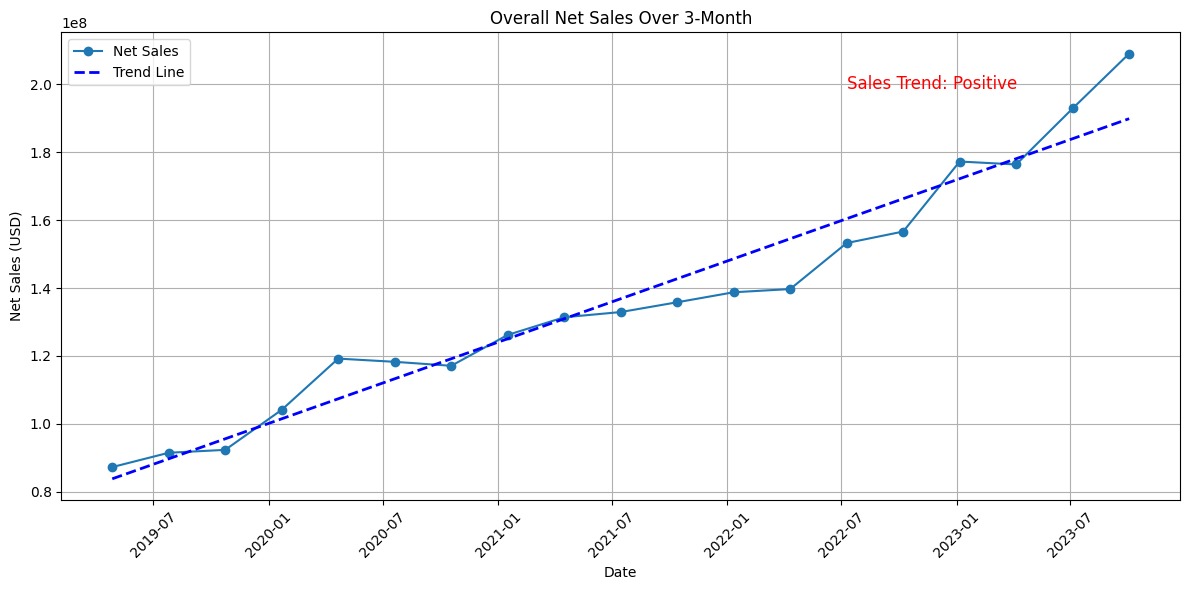

In [ ]:
from sklearn.linear_model import LinearRegression

# Sample data
df = pd.read_csv('/content/drive/MyDrive/Preprocessed dataset/Preprocessed dataset/sales_month_wise_90.csv', parse_dates=['START_DATE'], dayfirst=True)

# Convert START_DATE to datetime
df['START_DATE'] = pd.to_datetime(df['START_DATE'], format='%d-%m-%Y')
# Prepare data for linear regression
X = np.array(range(len(df))).reshape(-1, 1)
y = df['NET_SALES_FINAL_USD_AMOUNT'].values

# Fit linear regression model
model = LinearRegression()
model.fit(X, y)

# Get the slope (coefficient)
slope = model.coef_[0]

# Determine the trend
trend = "Positive" if slope > 0 else "Negative"

# Plot overall net sales
plt.figure(figsize=(12, 6))
plt.plot(df['START_DATE'], df['NET_SALES_FINAL_USD_AMOUNT'], marker='o', label='Net Sales')
plt.title('Overall Net Sales Over 3-Month')
plt.xlabel('Date')
plt.ylabel('Net Sales (USD)')
plt.xticks(rotation=45)
plt.grid()

# Add text annotation for the trend
trend_text = f'Sales Trend: {trend}'
plt.text(df['START_DATE'].iloc[int(len(df) * 0.7)], max(df['NET_SALES_FINAL_USD_AMOUNT']) * 0.95, trend_text, fontsize=12, color='red')

# Add linear regression line to the plot
plt.plot(df['START_DATE'], model.predict(X), color='blue', linestyle='--', linewidth=2, label='Trend Line')
plt.legend()

plt.tight_layout()
plt.show()


1-Week Net Sales visualization

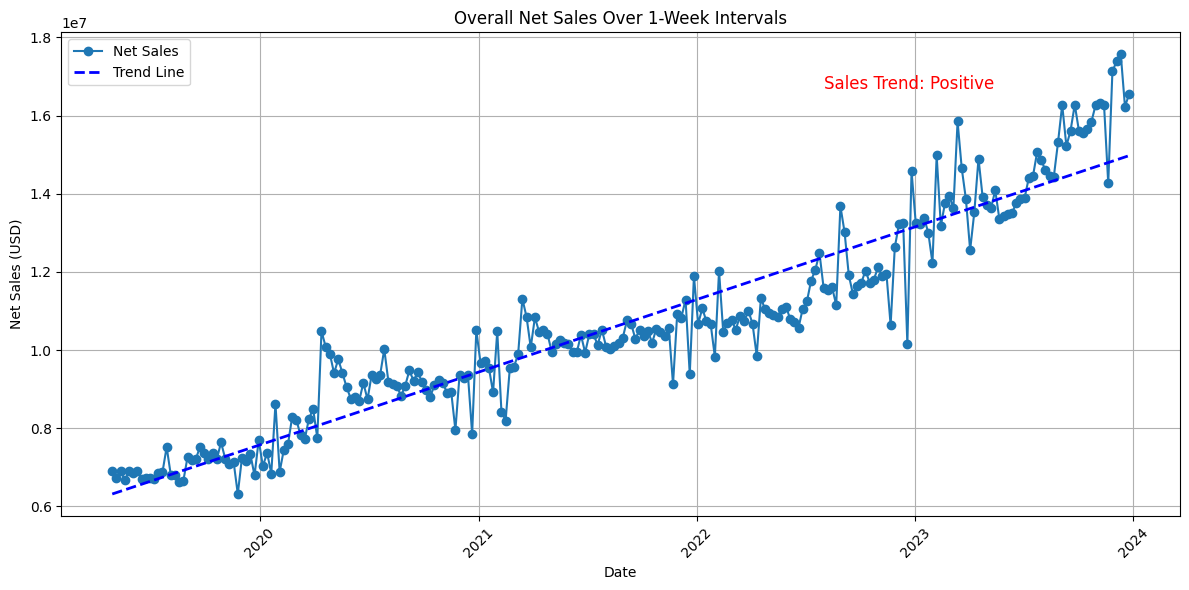

In [ ]:
# Sample data
df = pd.read_csv('/content/drive/MyDrive/Preprocessed dataset/Preprocessed dataset/sales_month_wise_7.csv', parse_dates=['START_DATE'], dayfirst=True)

# Convert START_DATE to datetime
df['START_DATE'] = pd.to_datetime(df['START_DATE'], format='%d-%m-%Y')
# Prepare data for linear regression
X = np.array(range(len(df))).reshape(-1, 1)
y = df['NET_SALES_FINAL_USD_AMOUNT'].values

# Fit linear regression model
model = LinearRegression()
model.fit(X, y)

# Get the slope (coefficient)
slope = model.coef_[0]

# Determine the trend
trend = "Positive" if slope > 0 else "Negative"

plt.figure(figsize=(12, 6))
plt.plot(df['START_DATE'], df['NET_SALES_FINAL_USD_AMOUNT'], marker='o', label='Net Sales')
plt.title('Overall Net Sales Over 1-Week Intervals')
plt.xlabel('Date')
plt.ylabel('Net Sales (USD)')
plt.xticks(rotation=45)
plt.grid()

# Add text annotation for the trend
trend_text = f'Sales Trend: {trend}'
plt.text(df['START_DATE'].iloc[int(len(df) * 0.7)], max(df['NET_SALES_FINAL_USD_AMOUNT']) * 0.95, trend_text, fontsize=12, color='red')

# Add linear regression line to the plot
plt.plot(df['START_DATE'], model.predict(X), color='blue', linestyle='--', linewidth=2, label='Trend Line')
plt.legend()

plt.tight_layout()
plt.show()


## 2.1.2) Store-Wise Analysis


## 2.1.1 Net Sales Visualization over 3-Months, 1-Week Intervals

This section presents a detailed analysis of net sales data for individual stores, identifying stores with maximum returns and detecting stores with negative sales trends. The dataset covers a 3-month period, with visualizations provided at monthly and weekly intervals to highlight trends and variations.

- **Net Sales Visualization for All Stores:** Net sales data for each store is plotted over the specified period. Helps identify general sales patterns and variations among different stores.

- **Identification of Top 10 Stores with Maximum Returns:** Using linear regression analysis, the top 10 stores with the highest slopes (indicative of maximum returns) are identified. These stores are highlighted to showcase the best-performing locations.

- **Identification of Stores with Negative Sales Trends:** Stores exhibiting negative sales trends are identified by analyzing the slopes of their respective linear regression lines, and looking at their percentage losses. Highlighting these stores is crucial for understanding potential issues and areas requiring intervention.


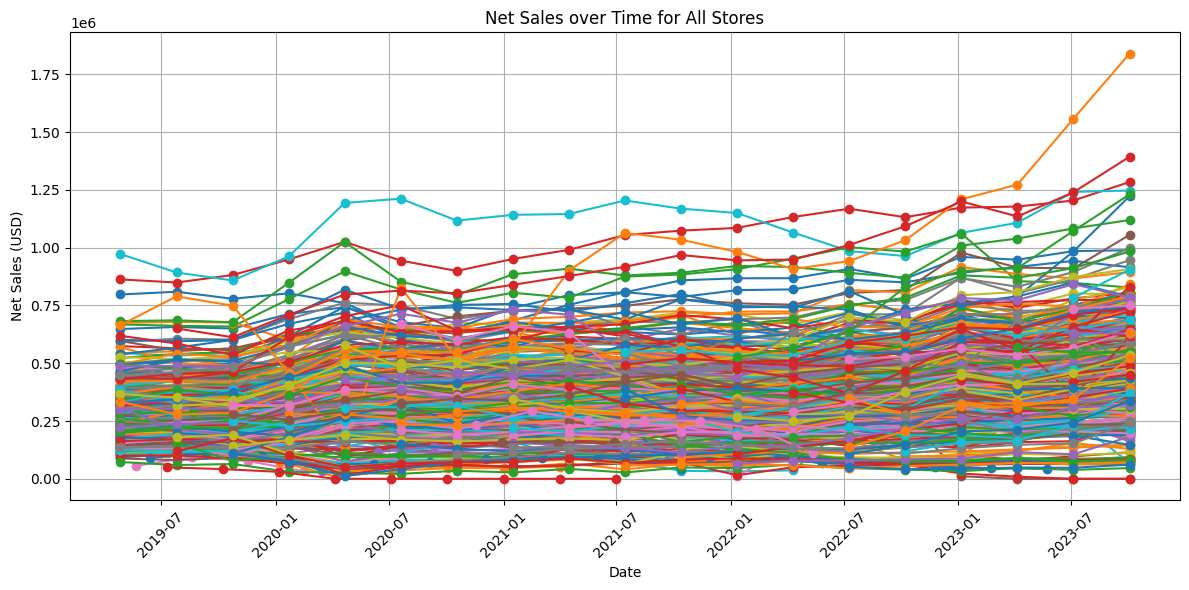

Top 10 stores with maximum returns (highest slopes):
Store 2301: Slope 121279.65999999964
Store 2155: Slope 99451.23583333335
Store 2223: Slope 83741.09499999988
Store 7029: Slope 66638.1162857143
Store 7027: Slope 58252.47361999999
Store 1479: Slope 56041.03975438594
Store 2007: Slope 44594.34999999992
Store 7028: Slope 41641.14428571428
Store 2041: Slope 41237.24678571431
Store 7020: Slope 40572.01940476194


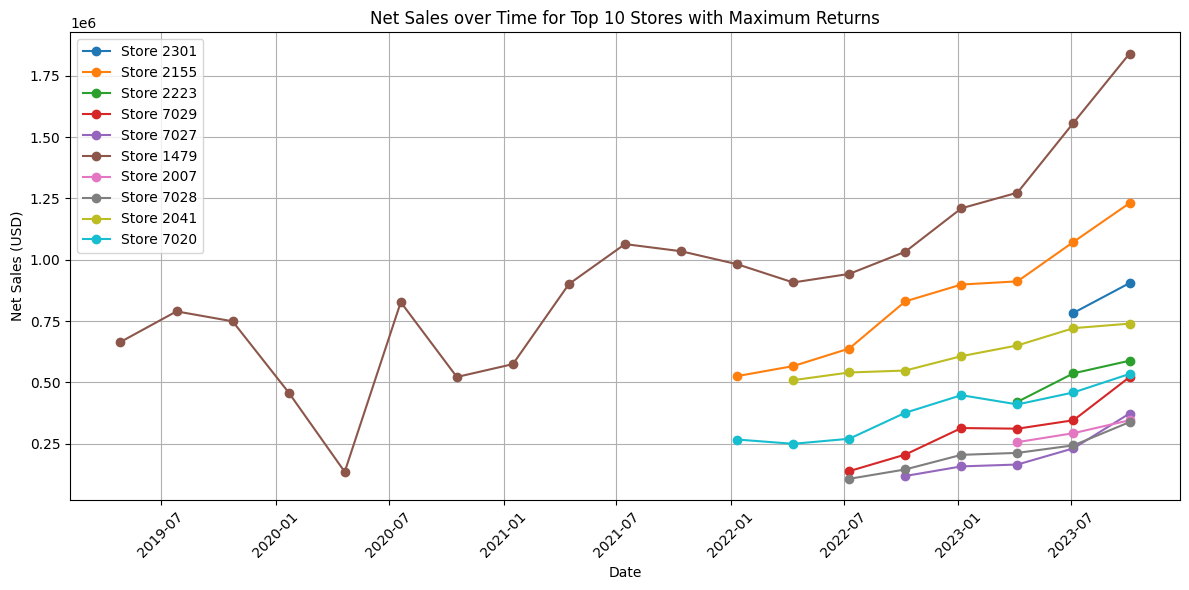

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# Read data from CSV file
df = pd.read_csv('/content/drive/MyDrive/Preprocessed dataset/Preprocessed dataset/sales_store_wise_90.csv', parse_dates=['START_DATE'], dayfirst=True)

# Convert START_DATE to datetime
df['START_DATE'] = pd.to_datetime(df['START_DATE'], format='%d-%m-%Y')

# Get unique store numbers
unique_stores = df['STORE_NUMBER'].unique()

# List to hold store numbers and their corresponding slopes
store_slopes = []

# Create plots for each store
plt.figure(figsize=(12, 6))
for store in unique_stores:
    df_store = df[df['STORE_NUMBER'] == store]

    # Prepare data for linear regression
    X = np.array(range(len(df_store))).reshape(-1, 1)
    y = df_store['NET_SALES_FINAL_USD_AMOUNT'].values

    # Fit linear regression model
    model = LinearRegression()
    model.fit(X, y)

    # Get the slope (coefficient)
    slope = model.coef_[0]

    # Append store number and slope to the list
    store_slopes.append((store, slope))

    # Plot the net sales for the store
    plt.plot(df_store['START_DATE'], df_store['NET_SALES_FINAL_USD_AMOUNT'], marker='o', label=f'Store {store}')

plt.title('Net Sales over Time for All Stores')
plt.xlabel('Date')
plt.ylabel('Net Sales (USD)')
plt.grid()
plt.xticks(rotation=45)
plt.tight_layout()

# Add legend outside the plot
#plt.legend(loc='upper left', bbox_to_anchor=(1, 1), ncol=1)
plt.show()

# Sort the stores by slope in descending order
store_slopes.sort(key=lambda x: x[1], reverse=True)

# Get the top 10 stores with the highest slopes
top_10_stores = store_slopes[:10]

# Print the top 10 stores with maximum returns
print("Top 10 stores with maximum returns (highest slopes):")
for store, slope in top_10_stores:
    print(f"Store {store}: Slope {slope}")

# Plot the net sales for the top 10 stores with the highest slopes
plt.figure(figsize=(12, 6))
for store, slope in top_10_stores:
    df_store = df[df['STORE_NUMBER'] == store]
    plt.plot(df_store['START_DATE'], df_store['NET_SALES_FINAL_USD_AMOUNT'], marker='o', label=f'Store {store}')

plt.title('Net Sales over Time for Top 10 Stores with Maximum Returns')
plt.xlabel('Date')
plt.ylabel('Net Sales (USD)')
plt.legend()
plt.grid()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Identifying stores with Negative Trends

In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression

# Read data from CSV file
df = pd.read_csv('/content/drive/MyDrive/Preprocessed dataset/Preprocessed dataset/sales_store_wise_90.csv', parse_dates=['START_DATE'], dayfirst=True)

# Convert START_DATE to datetime
df['START_DATE'] = pd.to_datetime(df['START_DATE'], format='%d-%m-%Y')

# Get unique store numbers
unique_stores = df['STORE_NUMBER'].unique()

# List to hold stores with negative trends and their percentage loss
negative_trend_stores = []

# Calculate percentage loss for stores with negative trends
for store in unique_stores:
    df_store = df[df['STORE_NUMBER'] == store]

    # Prepare data for linear regression
    X = np.array(range(len(df_store))).reshape(-1, 1)  # Convert index to array for regression
    y = df_store['NET_SALES_FINAL_USD_AMOUNT'].values

    # Fit linear regression model
    model = LinearRegression()
    model.fit(X, y)

    # Get the slope (coefficient)
    slope = model.coef_[0]

    # Check if slope is negative
    if slope < 0:
        # Calculate percentage loss from the first to the last sale
        initial_sales = df_store['NET_SALES_FINAL_USD_AMOUNT'].iloc[0]
        final_sales = df_store['NET_SALES_FINAL_USD_AMOUNT'].iloc[-1]

        if initial_sales > 0:
            percentage_loss = ((initial_sales - final_sales) / initial_sales) * 100

            # Only append if the percentage loss is positive
            if percentage_loss > 0:
                negative_trend_stores.append((store, percentage_loss))

# Create a DataFrame for negative trends
negative_trends_df = pd.DataFrame(negative_trend_stores, columns=['Store Number', 'Percentage Loss'])

# Display the DataFrame
print(negative_trends_df)


    Store Number  Percentage Loss
0            153         3.844826
1            315         7.545669
2            684         3.166626
3            739         4.461713
4            845       100.000000
5            846        42.540596
6           1008        51.941485
7           1136        52.469455
8           1273        14.974648
9           1289        33.045792
10          1420        37.426698
11          1448        45.451404
12          1449        23.739658
13          1477        28.023365
14          1478        51.635593
15          1489       100.000000
16          1533        36.129971
17          1542        12.153173
18          1547        22.681906
19          1576        25.299876
20          1632        37.764339
21          1661       100.000000
22          1791        48.376765
23          2083         6.846745
24          2115        42.678853
25          2153        23.022795
26          2221         9.882676
27          2222         4.695646
28          22

## 2.2) Promotions Analysis

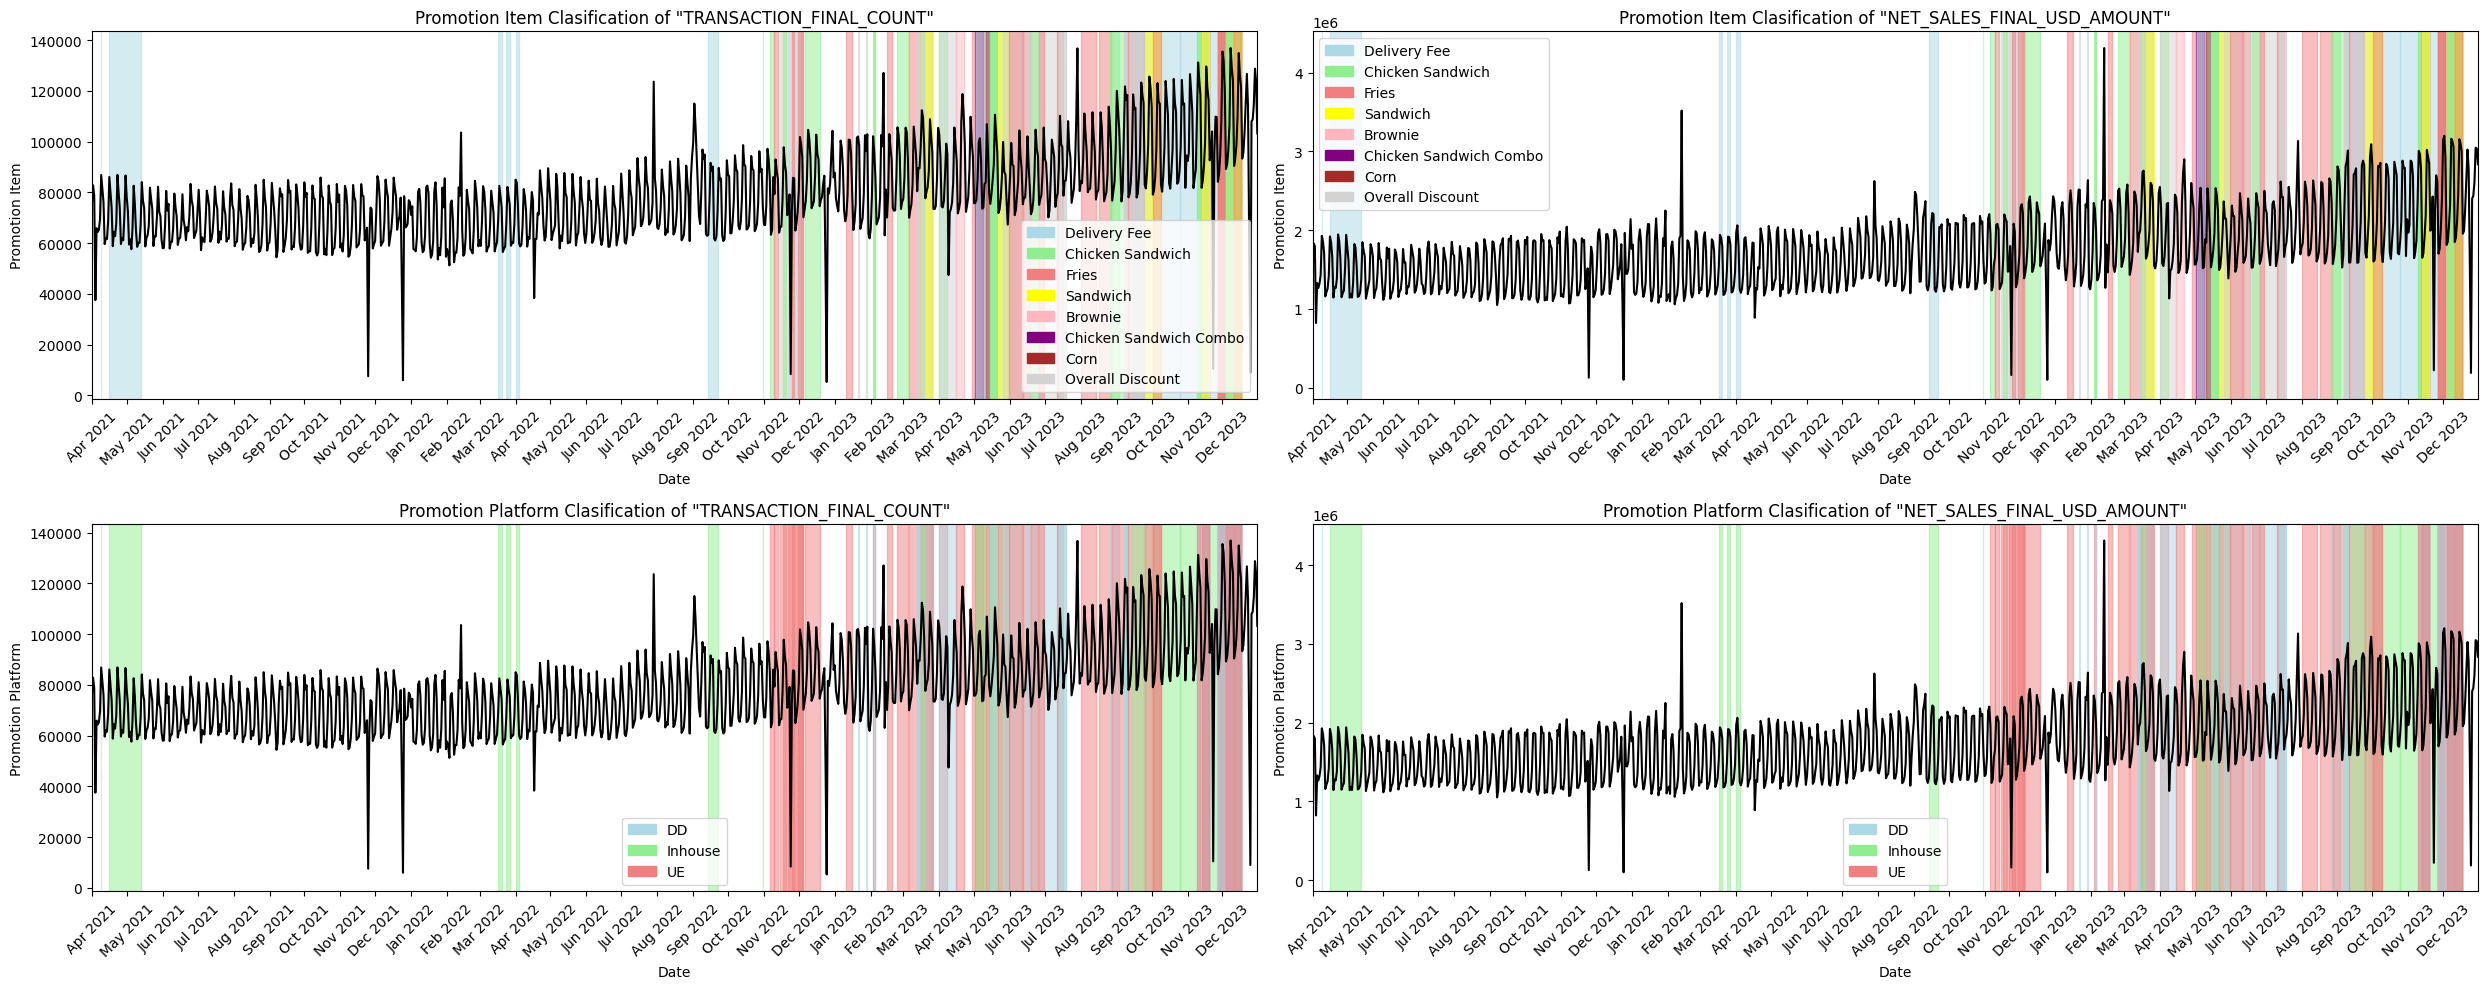

In [ ]:
# Load the promotions data
promotions_data_frame = pd.read_csv('promotions_final.csv')
df_storewise_rnn = pd.read_csv('sales_store_wise_1.csv')
df_monthwise_rnn = pd.read_csv('sales_month_wise_1.csv')

# Convert date columns to datetime objects
promotions_data_frame['PROMOTION_START_DATE'] = pd.to_datetime(promotions_data_frame['PROMOTION_START_DATE'], format='%d/%m/%Y')
promotions_data_frame['PROMOTION_END_DATE'] = pd.to_datetime(promotions_data_frame['PROMOTION_END_DATE'], format='%d/%m/%Y')

# Create a date range for the x-axis
# start_date = datetime(2019, 4, 24)
start_date = datetime(2021, 4, 1)
end_date = datetime(2023, 12, 31)
# end_date = datetime(2021, 12, 31)
date_range = pd.date_range(start=start_date, end=end_date)

fig2 = plt.figure(figsize=(25,10))
fig2.add_subplot(2,2,1)

##########################################
# Create a figure and axes
# fig2.add_subplot(1,2,2)

# fig, ax = plt.subplots(figsize=(9, 3))
ax = fig2.gca()
# Iterate over the promotions and plot them
for _, row in promotions_data_frame.iterrows():
    start = row['PROMOTION_START_DATE']
    end = row['PROMOTION_END_DATE']
    promotion_type = row['PROMOTION_ITEM']

    if promotion_type == 'Delivery Fee':
        color = 'lightblue'
    elif promotion_type == 'Chicken Sandwich':
        color = 'lightgreen'
    elif promotion_type == 'Fries':
        color = 'lightcoral'
    elif promotion_type == 'Sandwich':
        color = 'yellow'
    elif promotion_type == 'Brownie':
        color = 'lightpink'
    elif promotion_type == 'Chicken Sandwich Combo':
        color = 'purple'
    elif promotion_type == 'Corn':
        color = 'brown'
    else: # Overall Discount
        color = 'lightgray'

    ax.axvspan(start, end, color=color, alpha=0.5)

# Set the x-axis limits and format
ax.set_xlim(start_date, end_date)
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))

# Set the title and labels
plt.title('Promotion Item Clasification of "TRANSACTION_FINAL_COUNT"')
plt.xlabel('Date')
plt.ylabel('Promotion Item')
plt.plot(pd.to_datetime(df_monthwise_rnn['START_DATE'], format='%d-%m-%Y'), df_monthwise_rnn["TRANSACTION_FINAL_COUNT"], label='Original Data', color='black')

# Create a legend
legend_elements = [
    plt.Rectangle((0, 0), 1, 1, color='lightblue', label = 'Delivery Fee'),
    plt.Rectangle((0, 0), 1, 1, color='lightgreen', label = 'Chicken Sandwich'),
    plt.Rectangle((0, 0), 1, 1, color='lightcoral', label = 'Fries'),
    plt.Rectangle((0, 0), 1, 1, color='yellow', label = 'Sandwich'),
    plt.Rectangle((0, 0), 1, 1, color='lightpink', label = 'Brownie'),
    plt.Rectangle((0, 0), 1, 1, color='purple', label = 'Chicken Sandwich Combo'),
    plt.Rectangle((0, 0), 1, 1, color='brown', label = 'Corn'),
    plt.Rectangle((0, 0), 1, 1, color='lightgray', label = 'Overall Discount'),
]
ax.legend(handles=legend_elements)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)


##########################################
# Create a figure and axes
fig2.add_subplot(2,2,2)

# fig, ax = plt.subplots(figsize=(9, 3))
ax = fig2.gca()
# Iterate over the promotions and plot them
for _, row in promotions_data_frame.iterrows():
    start = row['PROMOTION_START_DATE']
    end = row['PROMOTION_END_DATE']
    promotion_type = row['PROMOTION_ITEM']

    if promotion_type == 'Delivery Fee':
        color = 'lightblue'
    elif promotion_type == 'Chicken Sandwich':
        color = 'lightgreen'
    elif promotion_type == 'Fries':
        color = 'lightcoral'
    elif promotion_type == 'Sandwich':
        color = 'yellow'
    elif promotion_type == 'Brownie':
        color = 'lightpink'
    elif promotion_type == 'Chicken Sandwich Combo':
        color = 'purple'
    elif promotion_type == 'Corn':
        color = 'brown'
    else: # Overall Discount
        color = 'lightgray'

    ax.axvspan(start, end, color=color, alpha=0.5)

# Set the x-axis limits and format
ax.set_xlim(start_date, end_date)
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))

# Set the title and labels
plt.title('Promotion Item Clasification of "NET_SALES_FINAL_USD_AMOUNT"')
plt.xlabel('Date')
plt.ylabel('Promotion Item')
plt.plot(pd.to_datetime(df_monthwise_rnn['START_DATE'], format='%d-%m-%Y'), df_monthwise_rnn["NET_SALES_FINAL_USD_AMOUNT"], label='Original Data', color='black')

# Create a legend
legend_elements = [
    plt.Rectangle((0, 0), 1, 1, color='lightblue', label = 'Delivery Fee'),
    plt.Rectangle((0, 0), 1, 1, color='lightgreen', label = 'Chicken Sandwich'),
    plt.Rectangle((0, 0), 1, 1, color='lightcoral', label = 'Fries'),
    plt.Rectangle((0, 0), 1, 1, color='yellow', label = 'Sandwich'),
    plt.Rectangle((0, 0), 1, 1, color='lightpink', label = 'Brownie'),
    plt.Rectangle((0, 0), 1, 1, color='purple', label = 'Chicken Sandwich Combo'),
    plt.Rectangle((0, 0), 1, 1, color='brown', label = 'Corn'),
    plt.Rectangle((0, 0), 1, 1, color='lightgray', label = 'Overall Discount'),
]
ax.legend(handles=legend_elements)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)


##########################################
# Create a figure and axes
fig2.add_subplot(2,2,3)

# fig, ax = plt.subplots(figsize=(9, 3))
ax = fig2.gca()
# Iterate over the promotions and plot them
for _, row in promotions_data_frame.iterrows():
    start = row['PROMOTION_START_DATE']
    end = row['PROMOTION_END_DATE']
    promotion_type = row['PLATFORM']

    if promotion_type == 'DD':
        color = 'lightblue'
    elif promotion_type == 'Inhouse':
        color = 'lightgreen'
    elif promotion_type == 'UE':
        color = 'lightcoral'
    else:
        color = 'lightgray'

    ax.axvspan(start, end, color=color, alpha=0.5)

# Set the x-axis limits and format
ax.set_xlim(start_date, end_date)
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))

# Set the title and labels
plt.title('Promotion Platform Clasification of "TRANSACTION_FINAL_COUNT"')
plt.xlabel('Date')
plt.ylabel('Promotion Platform')
plt.plot(pd.to_datetime(df_monthwise_rnn['START_DATE'], format='%d-%m-%Y'), df_monthwise_rnn["TRANSACTION_FINAL_COUNT"], label='Original Data', color='black')

# Create a legend
legend_elements = [
    plt.Rectangle((0, 0), 1, 1, color='lightblue', label='DD'),
    plt.Rectangle((0, 0), 1, 1, color='lightgreen', label='Inhouse'),
    plt.Rectangle((0, 0), 1, 1, color='lightcoral', label='UE'),
]
ax.legend(handles=legend_elements)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

##########################################
# Create a figure and axes
fig2.add_subplot(2,2,4)

# fig, ax = plt.subplots(figsize=(9, 3))
ax = fig2.gca()
# Iterate over the promotions and plot them
for _, row in promotions_data_frame.iterrows():
    start = row['PROMOTION_START_DATE']
    end = row['PROMOTION_END_DATE']
    promotion_type = row['PLATFORM']

    if promotion_type == 'DD':
        color = 'lightblue'
    elif promotion_type == 'Inhouse':
        color = 'lightgreen'
    elif promotion_type == 'UE':
        color = 'lightcoral'
    else:
        color = 'lightgray'

    ax.axvspan(start, end, color=color, alpha=0.5)

# Set the x-axis limits and format
ax.set_xlim(start_date, end_date)
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))

# Set the title and labels
plt.title('Promotion Platform Clasification of "NET_SALES_FINAL_USD_AMOUNT"')
plt.xlabel('Date')
plt.ylabel('Promotion Platform')
plt.plot(pd.to_datetime(df_monthwise_rnn['START_DATE'], format='%d-%m-%Y'), df_monthwise_rnn["NET_SALES_FINAL_USD_AMOUNT"], label='Original Data', color='black')

# Create a legend
legend_elements = [
    plt.Rectangle((0, 0), 1, 1, color='lightblue', label='DD'),
    plt.Rectangle((0, 0), 1, 1, color='lightgreen', label='Inhouse'),
    plt.Rectangle((0, 0), 1, 1, color='lightcoral', label='UE'),
]
ax.legend(handles=legend_elements)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Display the plot
plt.tight_layout()
plt.show()

<ipython-input-16-802c3c7332bc>:11: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df_monthwise_rnn['START_DATE'] = pd.to_datetime(df_monthwise_rnn['START_DATE'])


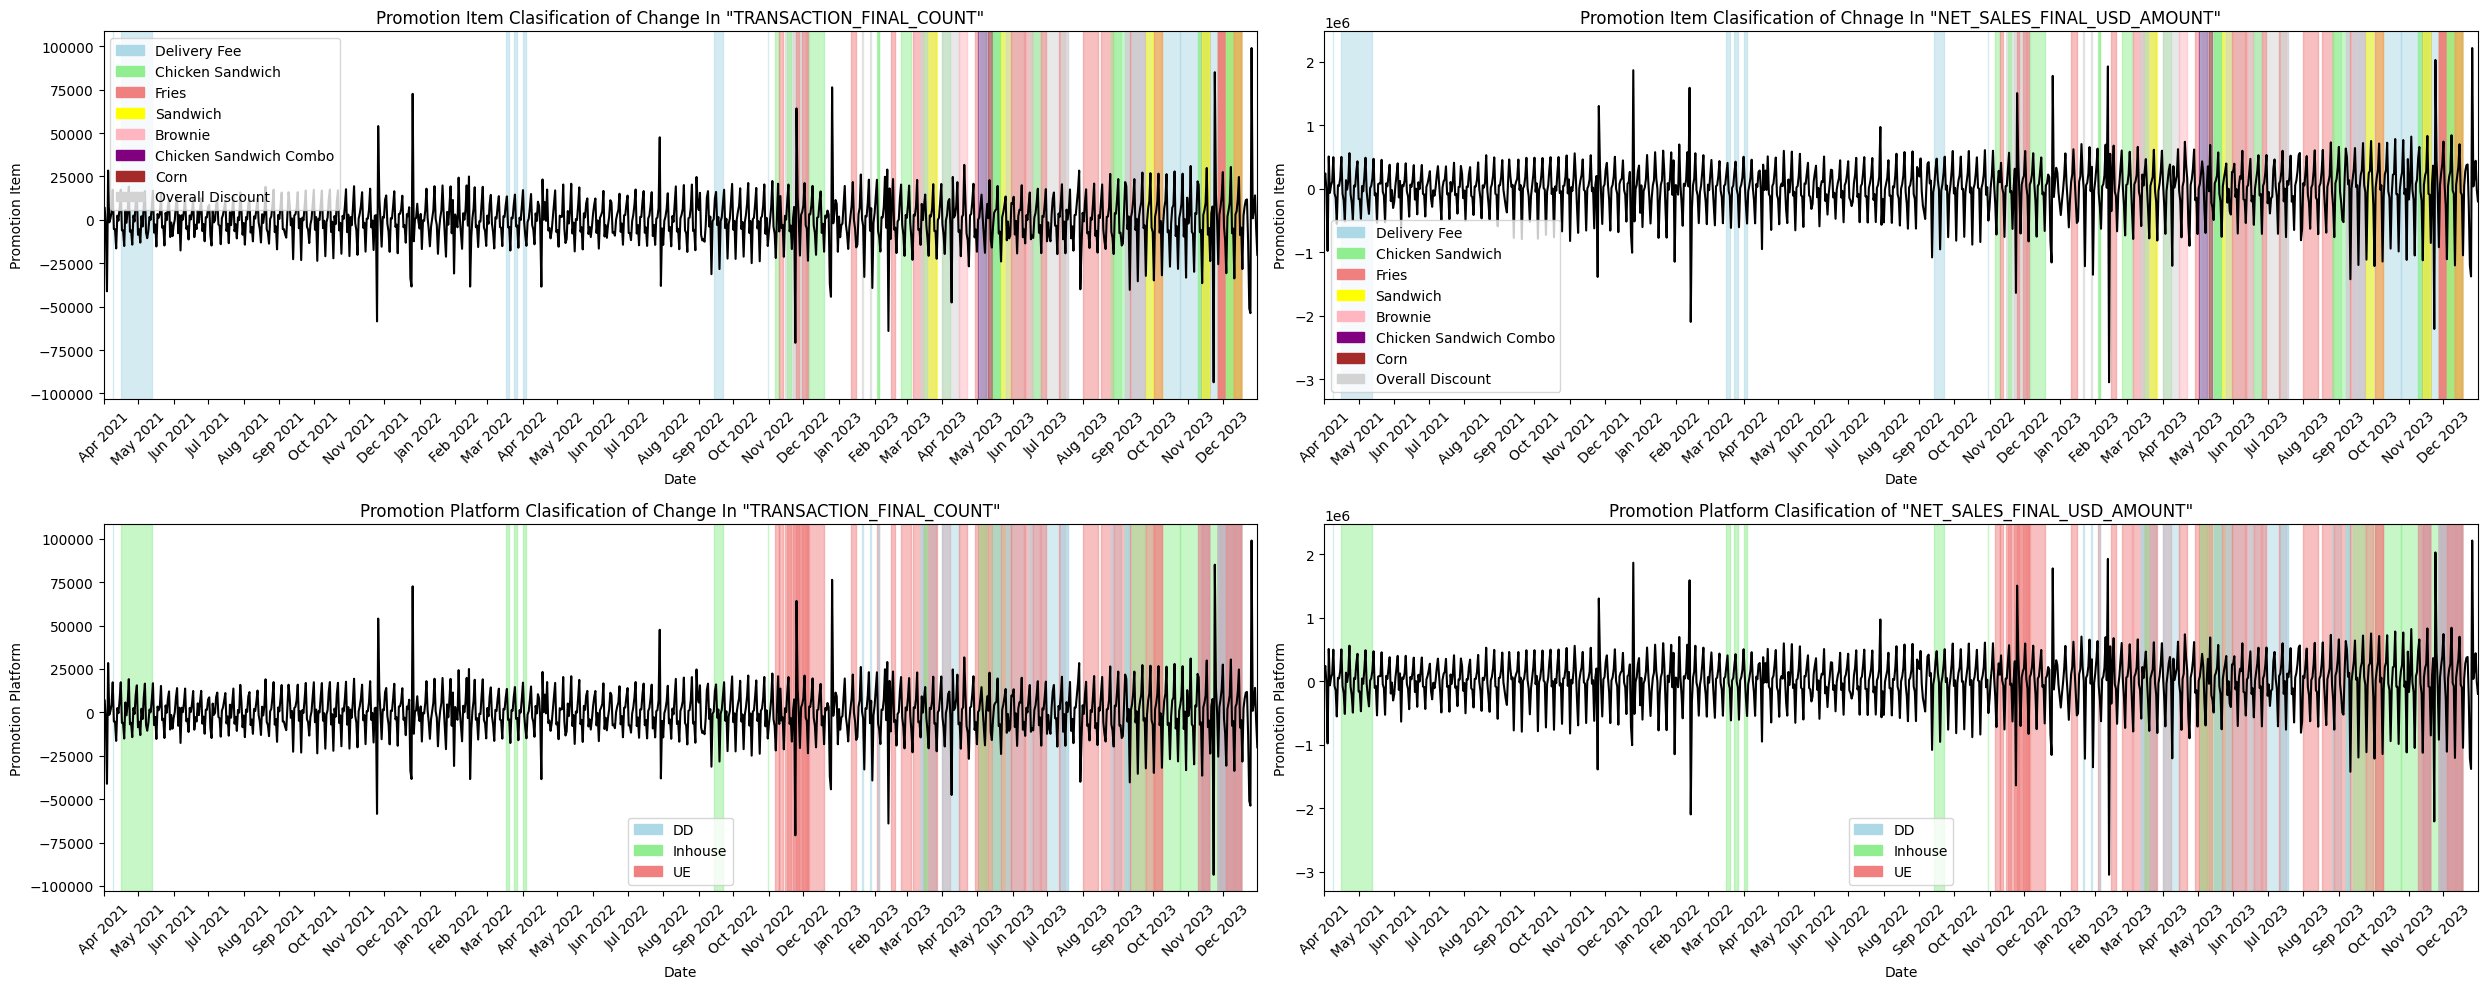

In [ ]:
promotions_data_frame = pd.read_csv('promotions_final.csv')
df_storewise_rnn = pd.read_csv('sales_store_wise_1.csv')
df_monthwise_rnn = pd.read_csv('sales_month_wise_1.csv')

# Convert date columns to datetime objects
promotions_data_frame['PROMOTION_START_DATE'] = pd.to_datetime(promotions_data_frame['PROMOTION_START_DATE'], format='%d/%m/%Y')
promotions_data_frame['PROMOTION_END_DATE'] = pd.to_datetime(promotions_data_frame['PROMOTION_END_DATE'], format='%d/%m/%Y')

# Load sales data and calculate derivative
df_monthwise_rnn = pd.read_csv('sales_month_wise_1.csv')
df_monthwise_rnn['START_DATE'] = pd.to_datetime(df_monthwise_rnn['START_DATE'])
df_monthwise_rnn.set_index('START_DATE', inplace=True)
derivative_trans = df_monthwise_rnn['TRANSACTION_FINAL_COUNT'].diff()
derivative_amt = df_monthwise_rnn['NET_SALES_FINAL_USD_AMOUNT'].diff()

# Create a date range for the x-axis
# start_date = datetime(2019, 4, 24)
start_date = datetime(2021, 4, 1)
end_date = datetime(2023, 12, 31)
# end_date = datetime(2021, 12, 31)
date_range = pd.date_range(start=start_date, end=end_date)

fig2 = plt.figure(figsize=(25,10))
fig2.add_subplot(2,2,1)

##########################################
# Create a figure and axes
# fig2.add_subplot(1,2,2)

# fig, ax = plt.subplots(figsize=(9, 3))
ax = fig2.gca()
# Iterate over the promotions and plot them
for _, row in promotions_data_frame.iterrows():
    start = row['PROMOTION_START_DATE']
    end = row['PROMOTION_END_DATE']
    promotion_type = row['PROMOTION_ITEM']

    if promotion_type == 'Delivery Fee':
        color = 'lightblue'
    elif promotion_type == 'Chicken Sandwich':
        color = 'lightgreen'
    elif promotion_type == 'Fries':
        color = 'lightcoral'
    elif promotion_type == 'Sandwich':
        color = 'yellow'
    elif promotion_type == 'Brownie':
        color = 'lightpink'
    elif promotion_type == 'Chicken Sandwich Combo':
        color = 'purple'
    elif promotion_type == 'Corn':
        color = 'brown'
    else: # Overall Discount
        color = 'lightgray'

    ax.axvspan(start, end, color=color, alpha=0.5)

# Set the x-axis limits and format
ax.set_xlim(start_date, end_date)
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))


# Set the title and labels
plt.title('Promotion Item Clasification of Change In "TRANSACTION_FINAL_COUNT"')
plt.xlabel('Date')
plt.ylabel('Promotion Item')
# plt.plot(pd.to_datetime(df_monthwise_rnn['START_DATE'], format='%d-%m-%Y'), df_monthwise_rnn["TRANSACTION_FINAL_COUNT"], label='Original Data', color='black')
plt.plot(derivative_trans.index, derivative_trans.values, label='Original Data', color='black')

# Create a legend
legend_elements = [
    plt.Rectangle((0, 0), 1, 1, color='lightblue', label = 'Delivery Fee'),
    plt.Rectangle((0, 0), 1, 1, color='lightgreen', label = 'Chicken Sandwich'),
    plt.Rectangle((0, 0), 1, 1, color='lightcoral', label = 'Fries'),
    plt.Rectangle((0, 0), 1, 1, color='yellow', label = 'Sandwich'),
    plt.Rectangle((0, 0), 1, 1, color='lightpink', label = 'Brownie'),
    plt.Rectangle((0, 0), 1, 1, color='purple', label = 'Chicken Sandwich Combo'),
    plt.Rectangle((0, 0), 1, 1, color='brown', label = 'Corn'),
    plt.Rectangle((0, 0), 1, 1, color='lightgray', label = 'Overall Discount'),
]
ax.legend(handles=legend_elements)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)


##########################################
# Create a figure and axes
fig2.add_subplot(2,2,2)

# fig, ax = plt.subplots(figsize=(9, 3))
ax = fig2.gca()
# Iterate over the promotions and plot them
for _, row in promotions_data_frame.iterrows():
    start = row['PROMOTION_START_DATE']
    end = row['PROMOTION_END_DATE']
    promotion_type = row['PROMOTION_ITEM']

    if promotion_type == 'Delivery Fee':
        color = 'lightblue'
    elif promotion_type == 'Chicken Sandwich':
        color = 'lightgreen'
    elif promotion_type == 'Fries':
        color = 'lightcoral'
    elif promotion_type == 'Sandwich':
        color = 'yellow'
    elif promotion_type == 'Brownie':
        color = 'lightpink'
    elif promotion_type == 'Chicken Sandwich Combo':
        color = 'purple'
    elif promotion_type == 'Corn':
        color = 'brown'
    else: # Overall Discount
        color = 'lightgray'

    ax.axvspan(start, end, color=color, alpha=0.5)

# Set the x-axis limits and format
ax.set_xlim(start_date, end_date)
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))

# Set the title and labels
plt.title('Promotion Item Clasification of Chnage In "NET_SALES_FINAL_USD_AMOUNT"')
plt.xlabel('Date')
plt.ylabel('Promotion Item')
# plt.plot(pd.to_datetime(df_monthwise_rnn['START_DATE'], format='%d-%m-%Y'), df_monthwise_rnn["NET_SALES_FINAL_USD_AMOUNT"], label='Original Data', color='black')
plt.plot(derivative_amt.index, derivative_amt.values, label='Original Data', color='black')

# Create a legend
legend_elements = [
    plt.Rectangle((0, 0), 1, 1, color='lightblue', label = 'Delivery Fee'),
    plt.Rectangle((0, 0), 1, 1, color='lightgreen', label = 'Chicken Sandwich'),
    plt.Rectangle((0, 0), 1, 1, color='lightcoral', label = 'Fries'),
    plt.Rectangle((0, 0), 1, 1, color='yellow', label = 'Sandwich'),
    plt.Rectangle((0, 0), 1, 1, color='lightpink', label = 'Brownie'),
    plt.Rectangle((0, 0), 1, 1, color='purple', label = 'Chicken Sandwich Combo'),
    plt.Rectangle((0, 0), 1, 1, color='brown', label = 'Corn'),
    plt.Rectangle((0, 0), 1, 1, color='lightgray', label = 'Overall Discount'),
]
ax.legend(handles=legend_elements)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)


##########################################
# Create a figure and axes
fig2.add_subplot(2,2,3)

# fig, ax = plt.subplots(figsize=(9, 3))
ax = fig2.gca()
# Iterate over the promotions and plot them
for _, row in promotions_data_frame.iterrows():
    start = row['PROMOTION_START_DATE']
    end = row['PROMOTION_END_DATE']
    promotion_type = row['PLATFORM']

    if promotion_type == 'DD':
        color = 'lightblue'
    elif promotion_type == 'Inhouse':
        color = 'lightgreen'
    elif promotion_type == 'UE':
        color = 'lightcoral'
    else:
        color = 'lightgray'

    ax.axvspan(start, end, color=color, alpha=0.5)

# Set the x-axis limits and format
ax.set_xlim(start_date, end_date)
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))

# Set the title and labels
plt.title('Promotion Platform Clasification of Change In "TRANSACTION_FINAL_COUNT"')
plt.xlabel('Date')
plt.ylabel('Promotion Platform')
# plt.plot(pd.to_datetime(df_monthwise_rnn['START_DATE'], format='%d-%m-%Y'), df_monthwise_rnn["TRANSACTION_FINAL_COUNT"], label='Original Data', color='black')
plt.plot(derivative_trans.index, derivative_trans.values, label='Original Data', color='black')

# Create a legend
legend_elements = [
    plt.Rectangle((0, 0), 1, 1, color='lightblue', label='DD'),
    plt.Rectangle((0, 0), 1, 1, color='lightgreen', label='Inhouse'),
    plt.Rectangle((0, 0), 1, 1, color='lightcoral', label='UE'),
]
ax.legend(handles=legend_elements)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

##########################################
# Create a figure and axes
fig2.add_subplot(2,2,4)

# fig, ax = plt.subplots(figsize=(9, 3))
ax = fig2.gca()
# Iterate over the promotions and plot them
for _, row in promotions_data_frame.iterrows():
    start = row['PROMOTION_START_DATE']
    end = row['PROMOTION_END_DATE']
    promotion_type = row['PLATFORM']

    if promotion_type == 'DD':
        color = 'lightblue'
    elif promotion_type == 'Inhouse':
        color = 'lightgreen'
    elif promotion_type == 'UE':
        color = 'lightcoral'
    else:
        color = 'lightgray'

    ax.axvspan(start, end, color=color, alpha=0.5)

# Set the x-axis limits and format
ax.set_xlim(start_date, end_date)
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))

# Set the title and labels
plt.title('Promotion Platform Clasification of "NET_SALES_FINAL_USD_AMOUNT"')
plt.xlabel('Date')
plt.ylabel('Promotion Platform')
# plt.plot(pd.to_datetime(df_monthwise_rnn['START_DATE'], format='%d-%m-%Y'), df_monthwise_rnn["NET_SALES_FINAL_USD_AMOUNT"], label='Original Data', color='black')
plt.plot(derivative_amt.index, derivative_amt.values, label='Original Data', color='black')

# Create a legend
legend_elements = [
    plt.Rectangle((0, 0), 1, 1, color='lightblue', label='DD'),
    plt.Rectangle((0, 0), 1, 1, color='lightgreen', label='Inhouse'),
    plt.Rectangle((0, 0), 1, 1, color='lightcoral', label='UE'),
]
ax.legend(handles=legend_elements)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Display the plot
plt.tight_layout()
plt.show()

#Forecasting Model

## SARIMAX




### Forecasting for 3 months

SARIMA Mean Squared Error: 826437499390.226
SARIMA Root Mean Squared Error: 909086.0791972484
SARIMA Mean Absolute Error: 748147.5329151537
SARIMA R^2: 0.4894784890125031


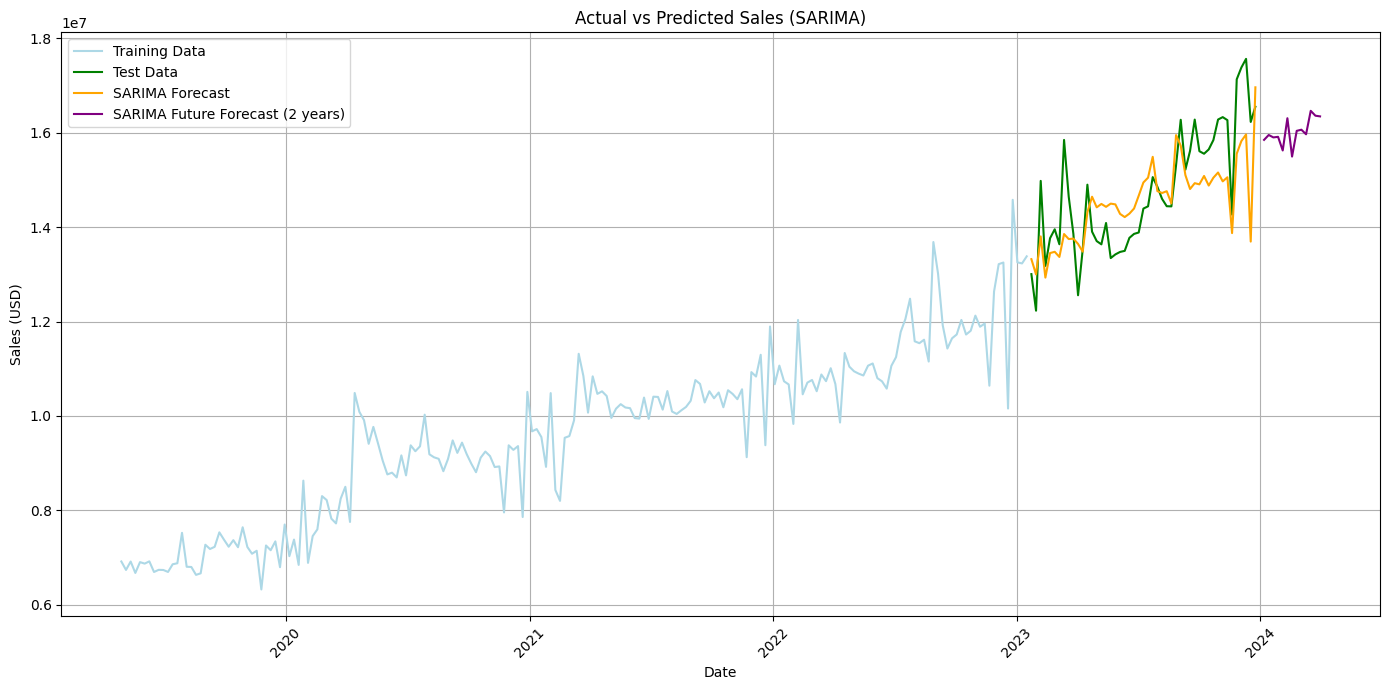

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
import warnings
warnings.filterwarnings('ignore')

# Load your CSV data
file_path = 'sales_month_wise_7.csv'
data = pd.read_csv(file_path)

# Convert START_DATE to datetime and set as index
data['START_DATE'] = pd.to_datetime(data['START_DATE'])
data.set_index('START_DATE', inplace=True)

# Sort data by date to ensure the split is correct
data = data.sort_index()

# Define the target variable
target = 'NET_SALES_FINAL_USD_AMOUNT'

# Prepare features and target for Linear Regression
# Use just the month and year as features for simplicity
data['MONTH'] = data.index.month
data['YEAR'] = data.index.year

features = ['MONTH', 'YEAR']

# Perform an 80-20 train-test split
train_size = int(len(data) * 0.8)
train, test = data[:train_size], data[train_size:]

# Train Linear Regression model
lr_model = LinearRegression()
lr_model.fit(train[features], train[target])

# Make Linear Regression predictions
lr_forecast = lr_model.predict(test[features])

# Train ARIMA model
arima_model = ARIMA(train[target], order=(5, 1, 0))  # Adjust the order as needed
arima_model_fit = arima_model.fit()

# Train SARIMA model
# Note: Adjust seasonal_order for weekly data if necessary (e.g., 52 weeks per year)
sarima_model = SARIMAX(train[target], order=(5, 1, 0), seasonal_order=(1, 1, 1, 52))  # Adjust orders and period as needed
sarima_model_fit = sarima_model.fit()

# # Make predictions for the test data period
# arima_forecast = arima_model_fit.forecast(steps=len(test))
sarima_forecast = sarima_model_fit.get_forecast(steps=len(test)).predicted_mean

# Make additional 3-month predictions (12 weeks)
future_steps = 13
sarima_future_forecast = sarima_model_fit.get_forecast(steps=len(test) + future_steps).predicted_mean[-future_steps:]

# Evaluate models
# Linear Regression metrics
lr_mse = mean_squared_error(test[target], lr_forecast)
lr_rmse = np.sqrt(lr_mse)
lr_mae = mean_absolute_error(test[target], lr_forecast)
lr_r2 = r2_score(test[target], lr_forecast)

# SARIMA metrics
sarima_mse = mean_squared_error(test[target], sarima_forecast)
sarima_rmse = np.sqrt(sarima_mse)
sarima_mae = mean_absolute_error(test[target], sarima_forecast)
sarima_r2 = r2_score(test[target], sarima_forecast)

print(f"SARIMA Mean Squared Error: {sarima_mse}")
print(f"SARIMA Root Mean Squared Error: {sarima_rmse}")
print(f"SARIMA Mean Absolute Error: {sarima_mae}")
print(f"SARIMA R^2: {sarima_r2}")

# print(f"Linear Regression Mean Squared Error: {lr_mse}")
# print(f"Linear Regression Root Mean Squared Error: {lr_rmse}")
# print(f"Linear Regression Mean Absolute Error: {lr_mae}")
# print(f"Linear Regression R^2: {lr_r2}")

# Create a new index for the future forecast
future_dates = pd.date_range(start=test.index[-1] + pd.DateOffset(weeks=1), periods=future_steps, freq='W')

# Plot actual vs predicted values
plt.figure(figsize=(14, 7))

# Plot training data
plt.plot(train.index, train[target], label='Training Data', color='lightblue')

# Plot test data
plt.plot(test.index, test[target], label='Test Data', color='green')

# # Plot ARIMA predictions
# plt.plot(test.index, arima_forecast, label='ARIMA Forecast', color='red')

# Plot SARIMA predictions
plt.plot(test.index, sarima_forecast, label='SARIMA Forecast', color='orange')

# Plot SARIMA future predictions
plt.plot(future_dates, sarima_future_forecast, label='SARIMA Future Forecast (2 years)', color='purple', linestyle='solid')

plt.xlabel('Date')
plt.ylabel('Sales (USD)')
plt.title('Actual vs Predicted Sales (SARIMA)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### Forecasting for 12 months

SARIMA Mean Squared Error: 826437499390.226
SARIMA Root Mean Squared Error: 909086.0791972484
SARIMA Mean Absolute Error: 748147.5329151537
SARIMA R^2: 0.4894784890125031


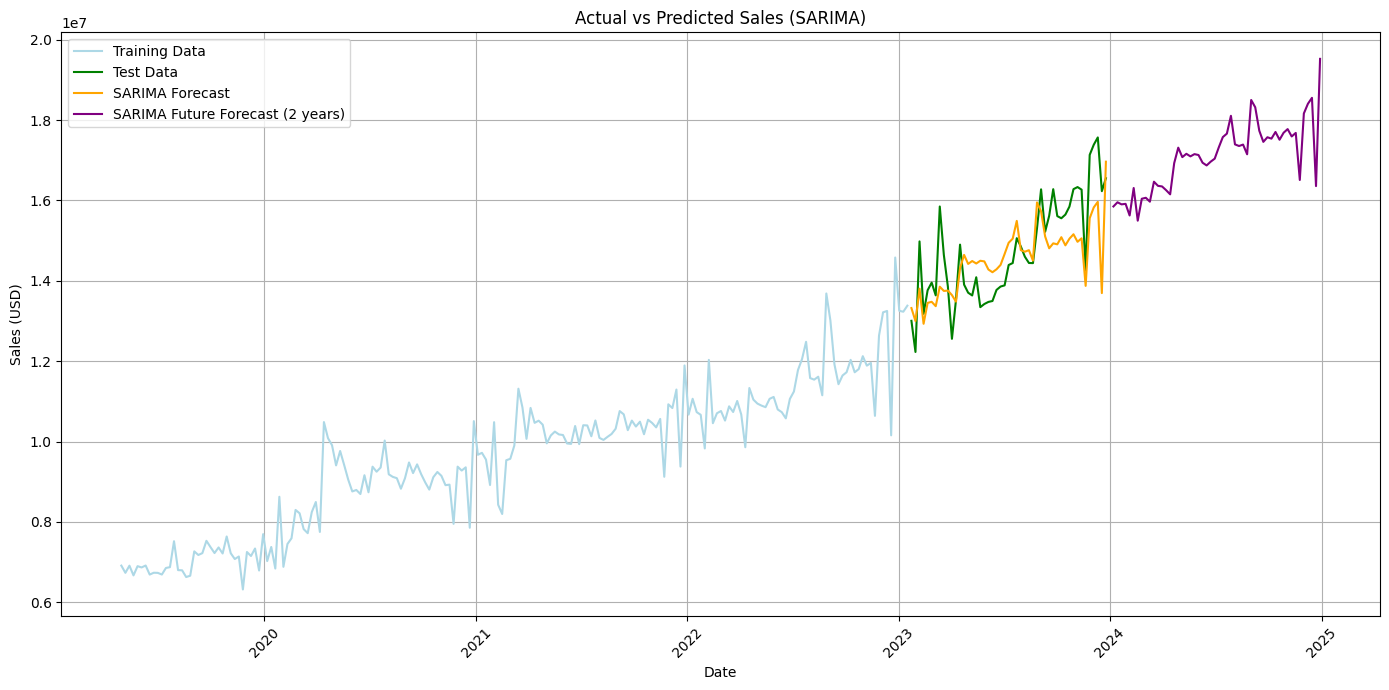

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
import warnings
warnings.filterwarnings('ignore')

# Load your CSV data
file_path = 'sales_month_wise_7.csv'
data = pd.read_csv(file_path)

# Convert START_DATE to datetime and set as index
data['START_DATE'] = pd.to_datetime(data['START_DATE'])
data.set_index('START_DATE', inplace=True)

# Sort data by date to ensure the split is correct
data = data.sort_index()

# Define the target variable
target = 'NET_SALES_FINAL_USD_AMOUNT'

# Prepare features and target for Linear Regression
# Use just the month and year as features for simplicity
data['MONTH'] = data.index.month
data['YEAR'] = data.index.year

features = ['MONTH', 'YEAR']

# Perform an 80-20 train-test split
train_size = int(len(data) * 0.8)
train, test = data[:train_size], data[train_size:]

# Train Linear Regression model
lr_model = LinearRegression()
lr_model.fit(train[features], train[target])

# Make Linear Regression predictions
lr_forecast = lr_model.predict(test[features])

# Train ARIMA model
arima_model = ARIMA(train[target], order=(5, 1, 0))  # Adjust the order as needed
arima_model_fit = arima_model.fit()

# Train SARIMA model
# Note: Adjust seasonal_order for weekly data if necessary (e.g., 52 weeks per year)
sarima_model = SARIMAX(train[target], order=(5, 1, 0), seasonal_order=(1, 1, 1, 52))  # Adjust orders and period as needed
sarima_model_fit = sarima_model.fit()

# # Make predictions for the test data period
# arima_forecast = arima_model_fit.forecast(steps=len(test))
sarima_forecast = sarima_model_fit.get_forecast(steps=len(test)).predicted_mean

# Make additional 3-month predictions (12 weeks)
future_steps = 52
sarima_future_forecast = sarima_model_fit.get_forecast(steps=len(test) + future_steps).predicted_mean[-future_steps:]

# Evaluate models
# Linear Regression metrics
lr_mse = mean_squared_error(test[target], lr_forecast)
lr_rmse = np.sqrt(lr_mse)
lr_mae = mean_absolute_error(test[target], lr_forecast)
lr_r2 = r2_score(test[target], lr_forecast)

# SARIMA metrics
sarima_mse = mean_squared_error(test[target], sarima_forecast)
sarima_rmse = np.sqrt(sarima_mse)
sarima_mae = mean_absolute_error(test[target], sarima_forecast)
sarima_r2 = r2_score(test[target], sarima_forecast)

print(f"SARIMA Mean Squared Error: {sarima_mse}")
print(f"SARIMA Root Mean Squared Error: {sarima_rmse}")
print(f"SARIMA Mean Absolute Error: {sarima_mae}")
print(f"SARIMA R^2: {sarima_r2}")

# print(f"Linear Regression Mean Squared Error: {lr_mse}")
# print(f"Linear Regression Root Mean Squared Error: {lr_rmse}")
# print(f"Linear Regression Mean Absolute Error: {lr_mae}")
# print(f"Linear Regression R^2: {lr_r2}")

# Create a new index for the future forecast
future_dates = pd.date_range(start=test.index[-1] + pd.DateOffset(weeks=1), periods=future_steps, freq='W')

# Plot actual vs predicted values
plt.figure(figsize=(14, 7))

# Plot training data
plt.plot(train.index, train[target], label='Training Data', color='lightblue')

# Plot test data
plt.plot(test.index, test[target], label='Test Data', color='green')

# # Plot ARIMA predictions
# plt.plot(test.index, arima_forecast, label='ARIMA Forecast', color='red')

# Plot SARIMA predictions
plt.plot(test.index, sarima_forecast, label='SARIMA Forecast', color='orange')

# Plot SARIMA future predictions
plt.plot(future_dates, sarima_future_forecast, label='SARIMA Future Forecast (2 years)', color='purple', linestyle='solid')

plt.xlabel('Date')
plt.ylabel('Sales (USD)')
plt.title('Actual vs Predicted Sales (SARIMA)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



## Ensemble Model: SARIMAX in combination with XGBoost

### Forecasting for 3 months

Combined Model Mean Squared Error: 804108903690.399
Combined Model Root Mean Squared Error: 896721.1961866403
Combined Model Mean Absolute Error: 742001.7309326569
Combined Model R^2: 0.5032717019576022


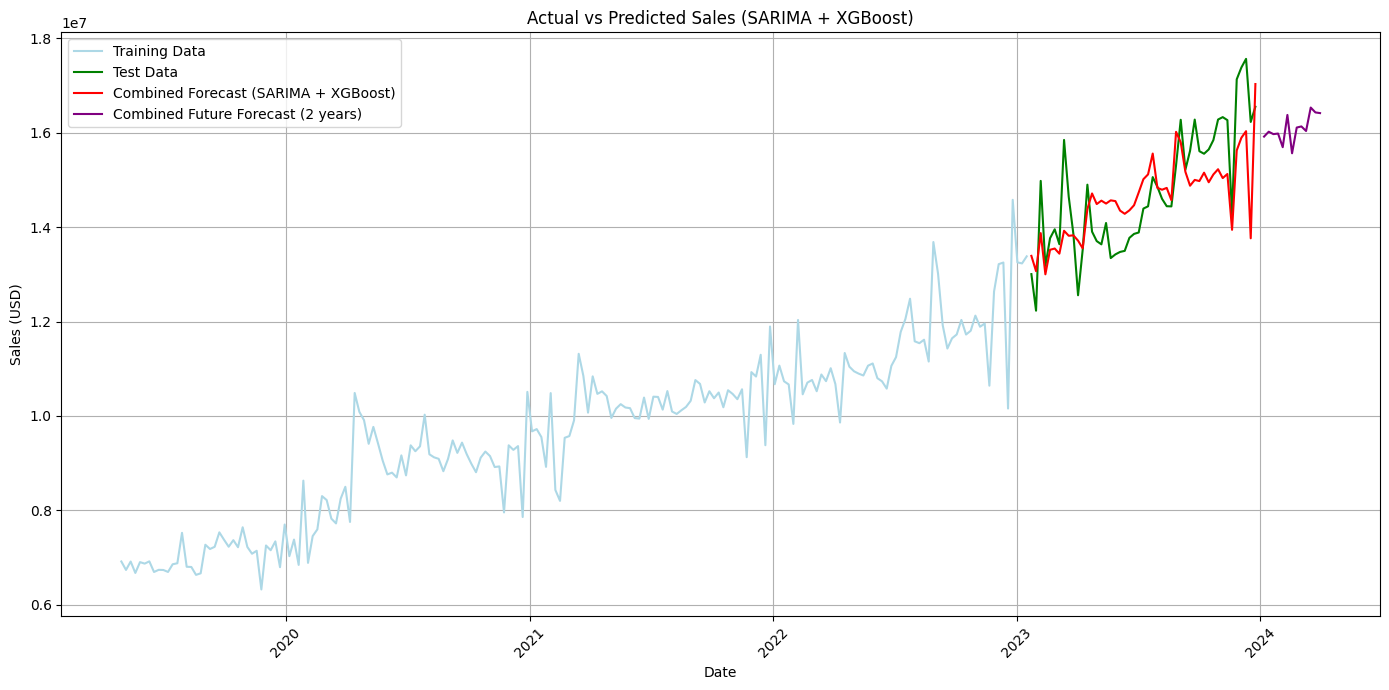

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

# Load your CSV data
file_path = 'sales_month_wise_7.csv'
data = pd.read_csv(file_path)

# Convert START_DATE to datetime and set as index
data['START_DATE'] = pd.to_datetime(data['START_DATE'])
data.set_index('START_DATE', inplace=True)

# Sort data by date to ensure the split is correct
data = data.sort_index()

# Define the target variable
target = 'NET_SALES_FINAL_USD_AMOUNT'

# Perform an 80-20 train-test split
train_size = int(len(data) * 0.8)
train, test = data[:train_size], data[train_size:]

# Train SARIMA model
# You may want to perform a grid search for the best SARIMA parameters
sarima_model = SARIMAX(train[target], order=(5, 1, 0), seasonal_order=(1, 1, 1, 52))  # Adjust orders and period as needed
sarima_model_fit = sarima_model.fit()

# Make predictions for the test data period
sarima_forecast = sarima_model_fit.get_forecast(steps=len(test)).predicted_mean

# Calculate residuals
residuals = train[target] - sarima_model_fit.fittedvalues

# Prepare data for XGBoost
train_features = np.arange(len(train)).reshape(-1, 1)
test_features = np.arange(len(train), len(train) + len(test)).reshape(-1, 1)

# Scale features
scaler = StandardScaler()
train_features_scaled = scaler.fit_transform(train_features)
test_features_scaled = scaler.transform(test_features)

# Hyperparameter tuning for XGBoost using GridSearchCV
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0]
}

xgb_model = xgb.XGBRegressor(objective='reg:squarederror')
tscv = TimeSeriesSplit(n_splits=5)
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=tscv, scoring='neg_mean_squared_error')
grid_search.fit(train_features_scaled, residuals)

# Best XGBoost model
best_xgb_model = grid_search.best_estimator_

# Forecast residuals using the best XGBoost model
xgb_forecast_residuals = best_xgb_model.predict(test_features_scaled)

# Combine SARIMA forecast and XGBoost forecast residuals
combined_forecast = sarima_forecast + xgb_forecast_residuals

# Evaluate combined model
combined_mse = mean_squared_error(test[target], combined_forecast)
combined_rmse = np.sqrt(combined_mse)
combined_mae = mean_absolute_error(test[target], combined_forecast)
combined_r2 = r2_score(test[target], combined_forecast)

print(f"Combined Model Mean Squared Error: {combined_mse}")
print(f"Combined Model Root Mean Squared Error: {combined_rmse}")
print(f"Combined Model Mean Absolute Error: {combined_mae}")
print(f"Combined Model R^2: {combined_r2}")

# Create a new index for the future forecast
future_steps = 13
future_features = np.arange(len(train) + len(test), len(train) + len(test) + future_steps).reshape(-1, 1)
future_features_scaled = scaler.transform(future_features)
future_dates = pd.date_range(start=test.index[-1] + pd.DateOffset(weeks=1), periods=future_steps, freq='W')

# Forecast future residuals using XGBoost
xgb_future_forecast_residuals = best_xgb_model.predict(future_features_scaled)

# Forecast future values using SARIMA
sarima_future_forecast = sarima_model_fit.get_forecast(steps=len(test) + future_steps).predicted_mean[-future_steps:]

# Combine future SARIMA forecast and XGBoost residuals forecast
combined_future_forecast = sarima_future_forecast + xgb_future_forecast_residuals

# Plot actual vs predicted values
plt.figure(figsize=(14, 7))

# Plot training data
plt.plot(train.index, train[target], label='Training Data', color='lightblue')

# Plot test data
plt.plot(test.index, test[target], label='Test Data', color='green')

# # Plot SARIMA predictions
# plt.plot(test.index, sarima_forecast, label='SARIMA Forecast', color='orange')

# Plot combined predictions
plt.plot(test.index, combined_forecast, label='Combined Forecast (SARIMA + XGBoost)', color='red')

# Plot combined future predictions
plt.plot(future_dates, combined_future_forecast, label='Combined Future Forecast (2 years)', color='purple', linestyle='solid')

plt.xlabel('Date')
plt.ylabel('Sales (USD)')
plt.title('Actual vs Predicted Sales (SARIMA + XGBoost)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### Forecasting for 12 months

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

# Load your CSV data
file_path = 'sales_month_wise_7.csv'
data = pd.read_csv(file_path)

# Convert START_DATE to datetime and set as index
data['START_DATE'] = pd.to_datetime(data['START_DATE'])
data.set_index('START_DATE', inplace=True)

# Sort data by date to ensure the split is correct
data = data.sort_index()

# Define the target variable
target = 'NET_SALES_FINAL_USD_AMOUNT'

# Perform an 80-20 train-test split
train_size = int(len(data) * 0.8)
train, test = data[:train_size], data[train_size:]

# Train SARIMA model
# You may want to perform a grid search for the best SARIMA parameters
sarima_model = SARIMAX(train[target], order=(5, 1, 0), seasonal_order=(1, 1, 1, 52))  # Adjust orders and period as needed
sarima_model_fit = sarima_model.fit()

# Make predictions for the test data period
sarima_forecast = sarima_model_fit.get_forecast(steps=len(test)).predicted_mean

# Calculate residuals
residuals = train[target] - sarima_model_fit.fittedvalues

# Prepare data for XGBoost
train_features = np.arange(len(train)).reshape(-1, 1)
test_features = np.arange(len(train), len(train) + len(test)).reshape(-1, 1)

# Scale features
scaler = StandardScaler()
train_features_scaled = scaler.fit_transform(train_features)
test_features_scaled = scaler.transform(test_features)

# Hyperparameter tuning for XGBoost using GridSearchCV
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0]
}

xgb_model = xgb.XGBRegressor(objective='reg:squarederror')
tscv = TimeSeriesSplit(n_splits=5)
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=tscv, scoring='neg_mean_squared_error')
grid_search.fit(train_features_scaled, residuals)

# Best XGBoost model
best_xgb_model = grid_search.best_estimator_

# Forecast residuals using the best XGBoost model
xgb_forecast_residuals = best_xgb_model.predict(test_features_scaled)

# Combine SARIMA forecast and XGBoost forecast residuals
combined_forecast = sarima_forecast + xgb_forecast_residuals

# Evaluate combined model
combined_mse = mean_squared_error(test[target], combined_forecast)
combined_rmse = np.sqrt(combined_mse)
combined_mae = mean_absolute_error(test[target], combined_forecast)
combined_r2 = r2_score(test[target], combined_forecast)

print(f"Combined Model Mean Squared Error: {combined_mse}")
print(f"Combined Model Root Mean Squared Error: {combined_rmse}")
print(f"Combined Model Mean Absolute Error: {combined_mae}")
print(f"Combined Model R^2: {combined_r2}")

# Create a new index for the future forecast
future_steps = 52
future_features = np.arange(len(train) + len(test), len(train) + len(test) + future_steps).reshape(-1, 1)
future_features_scaled = scaler.transform(future_features)
future_dates = pd.date_range(start=test.index[-1] + pd.DateOffset(weeks=1), periods=future_steps, freq='W')

# Forecast future residuals using XGBoost
xgb_future_forecast_residuals = best_xgb_model.predict(future_features_scaled)

# Forecast future values using SARIMA
sarima_future_forecast = sarima_model_fit.get_forecast(steps=len(test) + future_steps).predicted_mean[-future_steps:]

# Combine future SARIMA forecast and XGBoost residuals forecast
combined_future_forecast = sarima_future_forecast + xgb_future_forecast_residuals

# Plot actual vs predicted values
plt.figure(figsize=(14, 7))

# Plot training data
plt.plot(train.index, train[target], label='Training Data', color='lightblue')

# Plot test data
plt.plot(test.index, test[target], label='Test Data', color='green')

# # Plot SARIMA predictions
# plt.plot(test.index, sarima_forecast, label='SARIMA Forecast', color='orange')

# Plot combined predictions
plt.plot(test.index, combined_forecast, label='Combined Forecast (SARIMA + XGBoost)', color='red')

# Plot combined future predictions
plt.plot(future_dates, combined_future_forecast, label='Combined Future Forecast (2 years)', color='purple', linestyle='solid')

plt.xlabel('Date')
plt.ylabel('Sales (USD)')
plt.title('Actual vs Predicted Sales (SARIMA + XGBoost)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


FileNotFoundError: [Errno 2] No such file or directory: 'sales_month_wise_7.csv'

## RNN Prediction Model

MONTH_ORDER                   244
START_DATE                    244
END_DATE                      244
TRANSACTION_FINAL_COUNT       244
NET_SALES_FINAL_USD_AMOUNT    244
dtype: int64
(244, 5)
(196, 1) (48, 1)
Epoch 1/20
97/97 [==============================] - 4s 14ms/step - loss: 0.0179
Epoch 2/20
97/97 [==============================] - 1s 14ms/step - loss: 0.0143
Epoch 3/20
97/97 [==============================] - 1s 14ms/step - loss: 0.0131
Epoch 4/20
97/97 [==============================] - 1s 14ms/step - loss: 0.0124
Epoch 5/20
97/97 [==============================] - 1s 14ms/step - loss: 0.0116
Epoch 6/20
97/97 [==============================] - 2s 22ms/step - loss: 0.0115
Epoch 7/20
97/97 [==============================] - 3s 26ms/step - loss: 0.0106
Epoch 8/20
97/97 [==============================] - 1s 15ms/step - loss: 0.0102
Epoch 9/20
97/97 [==============================] - 1s 14ms/step - loss: 0.0114
Epoch 10/20
97/97 [==============================] - 1s 14ms/step - los

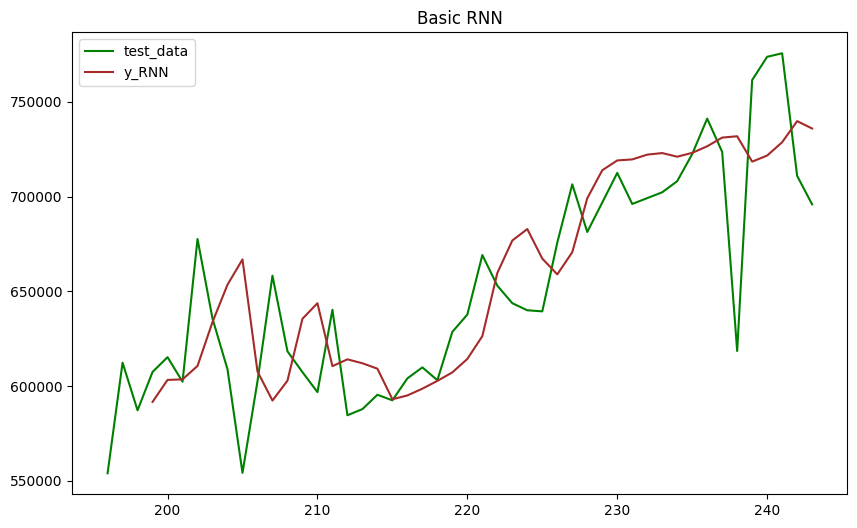

In [ ]:
import datetime as dt

sales_file_name = "sales_month_wise_7.csv"
df_monthwise_rnn = pd.read_csv(sales_file_name)
print(df_monthwise_rnn.nunique())
print(df_monthwise_rnn.shape)

# Setting 80 percent data for training
training_data_len = math.ceil(len(df_monthwise_rnn) * .8)
training_data_len

#Splitting the dataset
train_data = df_monthwise_rnn[:training_data_len].iloc[:,3:4]
test_data = df_monthwise_rnn[training_data_len:].iloc[:,3:4]
print(train_data.shape, test_data.shape)

# Selecting TRANSACTION_FINAL_COUNT values
dataset_train = train_data["TRANSACTION_FINAL_COUNT"].values
# Reshaping 1D to 2D array
dataset_train = np.reshape(dataset_train, (-1,1))
dataset_train.shape

scaler = MinMaxScaler(feature_range=(0,1))
# scaling dataset
scaled_train = scaler.fit_transform(dataset_train)

# Selecting TRANSACTION_FINAL_COUNT values
dataset_test = test_data["TRANSACTION_FINAL_COUNT"].values
# Reshaping 1D to 2D array
dataset_test = np.reshape(dataset_test, (-1,1))
scaled_test  = scaler.fit_transform(dataset_test)

X_train = []
y_train = []
for i in range(3, len(scaled_train)):
	X_train.append(scaled_train[i-3:i, 0])
	y_train.append(scaled_train[i, 0])

X_test = []
y_test = []
for i in range(3, len(scaled_test)):
	X_test.append(scaled_test[i-3:i, 0])
	y_test.append(scaled_test[i, 0])

# The data is converted to Numpy array
X_train, y_train = np.array(X_train), np.array(y_train)

#Reshaping
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1],1))
y_train = np.reshape(y_train, (y_train.shape[0],1))

# The data is converted to numpy array
X_test, y_test = np.array(X_test), np.array(y_test)

#Reshaping
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1],1))
y_test = np.reshape(y_test, (y_test.shape[0],1))

# initializing the RNN
regressor = Sequential()

# adding RNN layers and dropout regularization
regressor.add(SimpleRNN(units = 50,
						activation = "tanh",
						return_sequences = True,
						input_shape = (X_train.shape[1],1)))
regressor.add(Dropout(0.2))

regressor.add(SimpleRNN(units = 50,
						activation = "tanh",
						return_sequences = True))

regressor.add(SimpleRNN(units = 50,
						activation = "tanh",
						return_sequences = True))

regressor.add(SimpleRNN(units = 50))

# adding the output layer
regressor.add(Dense(units = 1,activation='sigmoid'))

# compiling RNN
regressor.compile(optimizer = SGD(learning_rate=0.01,
								momentum=0.9,
								nesterov=True),
				loss = "mean_squared_error")

# fitting the model
regressor.fit(X_train, y_train, epochs = 20, batch_size = 2)

# predictions with X_test data
y_RNN = regressor.predict(X_test)

# scaling back from 0-1 to original
y_RNN_O = scaler.inverse_transform(y_RNN)
print (test_data.shape, test_data["TRANSACTION_FINAL_COUNT"].shape)

# Evaluate the model
from sklearn.metrics import mean_squared_error, r2_score
mse = mean_squared_error(y_test, y_RNN_O)
r2 = r2_score(y_test, y_RNN_O)
rmse = math.sqrt(mse)
print(f'Mean Squared Error: {mse}')
print(f'R2 Score: {r2}')
print(f'RMSE: {rmse}')


#Plot for RNN predictions
plt.figure(figsize=(10, 6))
plt.plot(test_data.index, test_data["TRANSACTION_FINAL_COUNT"], label = "test_data", color = "g")
plt.plot(test_data.index[3:], y_RNN_O, label = "y_RNN", color = "brown")
plt.legend()
plt.title("Basic RNN")
plt.show()


In [ ]:
regressor.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 3, 50)             2600      
                                                                 
 dropout (Dropout)           (None, 3, 50)             0         
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 3, 50)             5050      
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 3, 50)             5050      
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, 50)                5050      
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 17801 (69.54 KB)
Trainable params: 17801 (

### Forecasting for 3 months

1/1 [==============================] - 0s 38ms/step


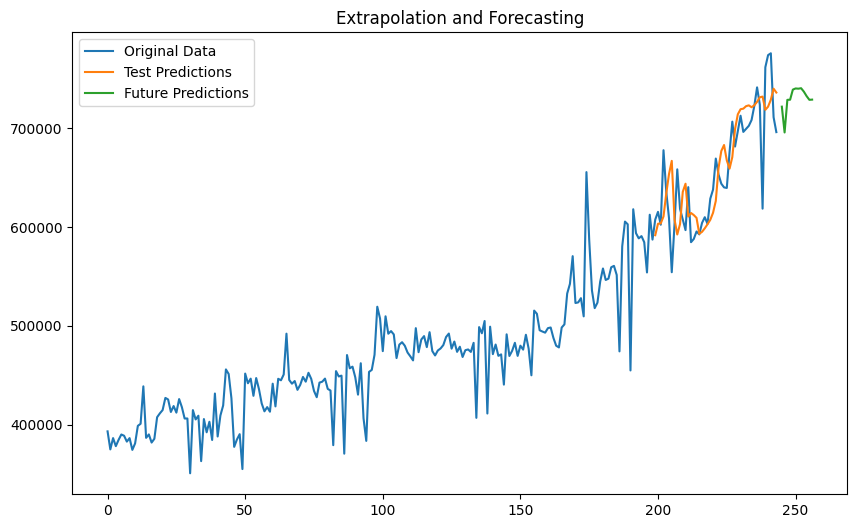

In [ ]:
import datetime as dt
future_predictions = []
scale_width = [4, 24, 12, 6]
last_sequence = X_test[-scale_width[0]:]  # Start with the last sequence from the test set
num_predictions = 12  # Number of future predictions to make
for _ in range(num_predictions):
    # next_pred = regressor.predict(np.reshape(last_sequence, (1, -1, 1)))
    next_pred = regressor.predict(np.reshape(last_sequence, (scale_width[0],3,1)))
    future_predictions.append(next_pred[0, 0])
    last_sequence = np.roll(last_sequence, -1)
    last_sequence[-1] = next_pred[0, 0]

# Scale back the predictions to the original range
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

# Extend the index for the future predictions
future_index = np.arange((len(test_data) + len(train_data)) + 1, (len(test_data) + len(train_data)) + 1 + num_predictions)

# Plot the original data, test predictions, and future predictions
plt.figure(figsize=(10, 6))
plt.plot(df_monthwise_rnn.index, df_monthwise_rnn["TRANSACTION_FINAL_COUNT"], label='Original Data')
plt.plot(test_data.index[3:], y_RNN_O, label='Test Predictions')
plt.plot(future_index, future_predictions, label='Future Predictions')
plt.legend()
plt.title("Extrapolation and Forecasting")
plt.show()

# Business Insights

In [ ]:
!pip install --upgrade xgboost


In [ ]:
!pip install --upgrade scikit-learn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 31.4 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.0
    Uninstalling scikit-learn-1.6.0:
      Successfully uninstalled scikit-learn-1.6.0


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

# Load your CSV data
file_path = 'merged_sales_promotions_filtered (6).xlsx'
data = pd.read_excel(file_path)

# Convert START_DATE to datetime and set as index
data['START_DATE'] = pd.to_datetime(data['START_DATE'])
data.set_index('START_DATE', inplace=True)

# Sort data by date to ensure the split is correct
data = data.sort_index()

# Take only the first 2000 rows for testing
data = data.iloc[:2000]

# Define the target variable
target = 'NET_SALES_FINAL_USD_AMOUNT'

# Perform an 80-20 train-test split
train_size = int(len(data) * 0.8)
train, test = data[:train_size], data[train_size:]

# Train SARIMA model
sarima_model = SARIMAX(train[target], order=(5, 1, 0), seasonal_order=(1, 1, 1, 52))  # Adjust orders and period as needed
sarima_model_fit = sarima_model.fit()

# Make predictions for the test data period
sarima_forecast = sarima_model_fit.get_forecast(steps=len(test)).predicted_mean

# Calculate residuals
residuals = train[target] - sarima_model_fit.fittedvalues
residuals = np.array(residuals)

# Prepare data for XGBoost
train_features = np.arange(len(train)).reshape(-1, 1)
test_features = np.arange(len(train), len(train) + len(test)).reshape(-1, 1)

# Scale features
scaler = StandardScaler()
train_features_scaled = scaler.fit_transform(train_features)
test_features_scaled = scaler.transform(test_features)

# Hyperparameter tuning for XGBoost using GridSearchCV
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0]
}

# Define and tune the XGBRegressor model
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_jobs=1)
tscv = TimeSeriesSplit(n_splits=5)
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    cv=tscv,
    scoring='neg_mean_squared_error'
)
# Fit the GridSearchCV
grid_search.fit(train_features_scaled, residuals.flatten())

# Best XGBoost model
best_xgb_model = grid_search.best_estimator_

# Forecast residuals using the best XGBoost model
xgb_forecast_residuals = best_xgb_model.predict(test_features_scaled)

# Combine SARIMA forecast and XGBoost forecast residuals
combined_forecast = sarima_forecast + xgb_forecast_residuals

# Evaluate combined model
combined_mse = mean_squared_error(test[target], combined_forecast)
combined_rmse = np.sqrt(combined_mse)
combined_mae = mean_absolute_error(test[target], combined_forecast)
combined_r2 = r2_score(test[target], combined_forecast)

# Print evaluation metrics
print(f"Combined Model Mean Squared Error: {combined_mse}")
print(f"Combined Model Root Mean Squared Error: {combined_rmse}")
print(f"Combined Model Mean Absolute Error: {combined_mae}")
print(f"Combined Model R^2: {combined_r2}")

# Create a new index for the future forecast
future_steps = 13
future_features = np.arange(len(train) + len(test), len(train) + len(test) + future_steps).reshape(-1, 1)
future_features_scaled = scaler.transform(future_features)
future_dates = pd.date_range(start=test.index[-1] + pd.DateOffset(weeks=1), periods=future_steps, freq='W')

# Forecast future residuals using XGBoost
xgb_future_forecast_residuals = best_xgb_model.predict(future_features_scaled)

# Forecast future values using SARIMA
sarima_future_forecast = sarima_model_fit.get_forecast(steps=len(test) + future_steps).predicted_mean[-future_steps:]

# Combine future SARIMA forecast and XGBoost residuals forecast
combined_future_forecast = sarima_future_forecast + xgb_future_forecast_residuals

# Plot actual vs predicted values
plt.figure(figsize=(14, 7))

# Plot training data
plt.plot(train.index, train[target], label='Training Data', color='lightblue')

# Plot test data
plt.plot(test.index, test[target], label='Test Data', color='green')

# Plot combined predictions
plt.plot(test.index, combined_forecast, label='Combined Forecast (SARIMA + XGBoost)', color='red')

# Plot combined future predictions
plt.plot(future_dates, combined_future_forecast, label='Combined Future Forecast', color='purple', linestyle='solid')

plt.xlabel('Date')
plt.ylabel('Sales (USD)')
plt.title('Actual vs Predicted Sales (SARIMA + XGBoost)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


AttributeError: 'super' object has no attribute '__sklearn_tags__'

In [ ]:
!pip show scikit-learn xgboost



Name: scikit-learn
Version: 1.6.1
Summary: A set of python modules for machine learning and data mining
Home-page: https://scikit-learn.org
Author: 
Author-email: 
License: BSD 3-Clause License

 Copyright (c) 2007-2024 The scikit-learn developers.
 All rights reserved.

 Redistribution and use in source and binary forms, with or without
 modification, are permitted provided that the following conditions are met:

 * Redistributions of source code must retain the above copyright notice, this
   list of conditions and the following disclaimer.

 * Redistributions in binary form must reproduce the above copyright notice,
   this list of conditions and the following disclaimer in the documentation
   and/or other materials provided with the distribution.

 * Neither the name of the copyright holder nor the names of its
   contributors may be used to endorse or promote products derived from
   this software without specific prior written permission.

 THIS SOFTWARE IS PROVIDED BY THE COPYR

In [ ]:
!pip install scikit-learn==1.5.0


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 55.1 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.1
    Uninstalling scikit-learn-1.6.1:
      Successfully uninstalled scikit-learn-1.6.1


Combined Model Mean Squared Error: 359263603.0496079
Combined Model Root Mean Squared Error: 18954.250263452992
Combined Model Mean Absolute Error: 16590.63508355198
Combined Model R^2: -1.7127022796103262


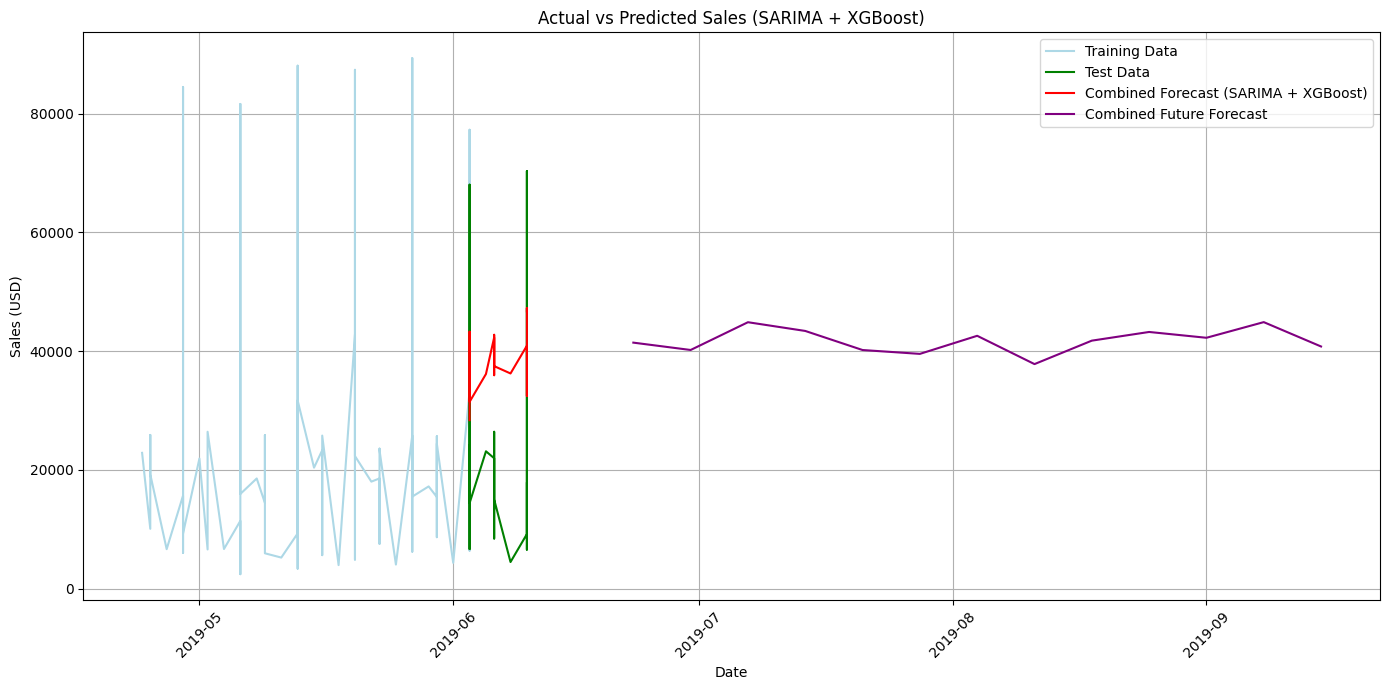

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

# Load your CSV data
file_path = 'merged_sales_promotions_filtered (6).xlsx'
data = pd.read_excel(file_path)

# Convert START_DATE to datetime and set as index
data['START_DATE'] = pd.to_datetime(data['START_DATE'])
data.set_index('START_DATE', inplace=True)

# Sort data by date to ensure the split is correct
data = data.sort_index()

# Take only the first 2000 rows for testing
data = data.iloc[:2000]

# Define the target variable
target = 'NET_SALES_FINAL_USD_AMOUNT'

# Perform an 80-20 train-test split
train_size = int(len(data) * 0.8)
train, test = data[:train_size], data[train_size:]

# Train SARIMA model
sarima_model = SARIMAX(train[target], order=(5, 1, 0), seasonal_order=(1, 1, 1, 52))  # Adjust orders and period as needed
sarima_model_fit = sarima_model.fit()

# Make predictions for the test data period
sarima_forecast = sarima_model_fit.get_forecast(steps=len(test)).predicted_mean

# Calculate residuals
residuals = train[target] - sarima_model_fit.fittedvalues
residuals = np.array(residuals)

# Prepare data for XGBoost
train_features = np.arange(len(train)).reshape(-1, 1)
test_features = np.arange(len(train), len(train) + len(test)).reshape(-1, 1)

# Scale features
scaler = StandardScaler()
train_features_scaled = scaler.fit_transform(train_features)
test_features_scaled = scaler.transform(test_features)

# Define and use the XGBRegressor model with default parameters (no GridSearchCV)
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_jobs=1)

# Train the XGBoost model on the residuals
xgb_model.fit(train_features_scaled, residuals.flatten())

# Forecast residuals using the trained XGBoost model
xgb_forecast_residuals = xgb_model.predict(test_features_scaled)

# Combine SARIMA forecast and XGBoost forecast residuals
combined_forecast = sarima_forecast + xgb_forecast_residuals

# Evaluate combined model
combined_mse = mean_squared_error(test[target], combined_forecast)
combined_rmse = np.sqrt(combined_mse)
combined_mae = mean_absolute_error(test[target], combined_forecast)
combined_r2 = r2_score(test[target], combined_forecast)

# Print evaluation metrics
print(f"Combined Model Mean Squared Error: {combined_mse}")
print(f"Combined Model Root Mean Squared Error: {combined_rmse}")
print(f"Combined Model Mean Absolute Error: {combined_mae}")
print(f"Combined Model R^2: {combined_r2}")

# Create a new index for the future forecast
future_steps = 13
future_features = np.arange(len(train) + len(test), len(train) + len(test) + future_steps).reshape(-1, 1)
future_features_scaled = scaler.transform(future_features)
future_dates = pd.date_range(start=test.index[-1] + pd.DateOffset(weeks=1), periods=future_steps, freq='W')

# Forecast future residuals using XGBoost
xgb_future_forecast_residuals = xgb_model.predict(future_features_scaled)

# Forecast future values using SARIMA
sarima_future_forecast = sarima_model_fit.get_forecast(steps=len(test) + future_steps).predicted_mean[-future_steps:]

# Combine future SARIMA forecast and XGBoost residuals forecast
combined_future_forecast = sarima_future_forecast + xgb_future_forecast_residuals

# Plot actual vs predicted values
plt.figure(figsize=(14, 7))

# Plot training data
plt.plot(train.index, train[target], label='Training Data', color='lightblue')

# Plot test data
plt.plot(test.index, test[target], label='Test Data', color='green')

# Plot combined predictions
plt.plot(test.index, combined_forecast, label='Combined Forecast (SARIMA + XGBoost)', color='red')

# Plot combined future predictions
plt.plot(future_dates, combined_future_forecast, label='Combined Future Forecast', color='purple', linestyle='solid')

plt.xlabel('Date')
plt.ylabel('Sales (USD)')
plt.title('Actual vs Predicted Sales (SARIMA + XGBoost)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

# Load your CSV data
file_path = 'merged_sales_promotions_filtered (6).xlsx'
data = pd.read_excel(file_path)

# Convert START_DATE to datetime and set as index
data['START_DATE'] = pd.to_datetime(data['START_DATE'])
data.set_index('START_DATE', inplace=True)

# Sort data by date to ensure the split is correct
data = data.sort_index()

# Take only the first 2000 rows for testing
data = data.iloc[:2000]

# Create a promotion_active column (1 if promotion is active, 0 otherwise)
data['promotion_active'] = np.where(data['PROMOTION_TYPE'].notna(), 1, 0)

# Define the target variable
target = 'NET_SALES_FINAL_USD_AMOUNT'

# Perform an 80-20 train-test split
train_size = int(len(data) * 0.8)
train, test = data[:train_size], data[train_size:]

# Train SARIMA model with promotion as exogenous variable
sarima_model = SARIMAX(train[target], order=(5, 1, 0), seasonal_order=(1, 1, 1, 52), exog=train[['promotion_active']])
sarima_model_fit = sarima_model.fit()

# Make predictions for the test data period, including promotions as exogenous variable
sarima_forecast = sarima_model_fit.get_forecast(steps=len(test), exog=test[['promotion_active']]).predicted_mean

# Calculate residuals
residuals = train[target] - sarima_model_fit.fittedvalues
residuals = np.array(residuals)

# Prepare data for XGBoost, including promotion_active as a feature
train_features = np.arange(len(train)).reshape(-1, 1)
test_features = np.arange(len(train), len(train) + len(test)).reshape(-1, 1)
train_features = np.hstack((train_features, train[['promotion_active']].values))  # Adding promotion_active to features
test_features = np.hstack((test_features, test[['promotion_active']].values))  # Adding promotion_active to features

# Scale features
scaler = StandardScaler()
train_features_scaled = scaler.fit_transform(train_features)
test_features_scaled = scaler.transform(test_features)

# Define and use the XGBRegressor model with default parameters (no GridSearchCV)
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_jobs=1)

# Train the XGBoost model on the residuals
xgb_model.fit(train_features_scaled, residuals.flatten())

# Forecast residuals using the trained XGBoost model
xgb_forecast_residuals = xgb_model.predict(test_features_scaled)

# Combine SARIMA forecast and XGBoost forecast residuals
combined_forecast = sarima_forecast + xgb_forecast_residuals

# Evaluate combined model
combined_mse = mean_squared_error(test[target], combined_forecast)
combined_rmse = np.sqrt(combined_mse)
combined_mae = mean_absolute_error(test[target], combined_forecast)
combined_r2 = r2_score(test[target], combined_forecast)

# Print evaluation metrics
print(f"Combined Model Mean Squared Error: {combined_mse}")
print(f"Combined Model Root Mean Squared Error: {combined_rmse}")
print(f"Combined Model Mean Absolute Error: {combined_mae}")
print(f"Combined Model R^2: {combined_r2}")

# Create a new index for the future forecast
future_steps = 13
future_features = np.arange(len(train) + len(test), len(train) + len(test) + future_steps).reshape(-1, 1)
future_features = np.hstack((future_features, np.zeros((future_steps, 1))))  # Assuming no promotions in future (can adjust if needed)
future_features_scaled = scaler.transform(future_features)
future_dates = pd.date_range(start=test.index[-1] + pd.DateOffset(weeks=1), periods=future_steps, freq='W')

# Forecast future residuals using XGBoost
xgb_future_forecast_residuals = xgb_model.predict(future_features_scaled)

# Forecast future values using SARIMA (future values of promotion_active can be passed if known)
sarima_future_forecast = sarima_model_fit.get_forecast(steps=len(test) + future_steps, exog=future_features).predicted_mean[-future_steps:]

# Combine future SARIMA forecast and XGBoost residuals forecast
combined_future_forecast = sarima_future_forecast + xgb_future_forecast_residuals

# Plot actual vs predicted values
plt.figure(figsize=(14, 7))

# Plot training data
plt.plot(train.index, train[target], label='Training Data', color='lightblue')

# Plot test data
plt.plot(test.index, test[target], label='Test Data', color='green')

# Plot combined predictions
plt.plot(test.index, combined_forecast, label='Combined Forecast (SARIMA + XGBoost)', color='red')

# Plot combined future predictions
plt.plot(future_dates, combined_future_forecast, label='Combined Future Forecast', color='purple', linestyle='solid')

# Mark promotion start points
promotion_starts = data[data['promotion_active'] == 1].index
for promo_start in promotion_starts:
    plt.axvline(x=promo_start, color='orange', linestyle='--', label='Promotion Start')

plt.xlabel('Date')
plt.ylabel('Sales (USD)')
plt.title('Actual vs Predicted Sales (SARIMA + XGBoost) with Promotions')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Combined Model Mean Squared Error: 245774377.8757572
Combined Model Root Mean Squared Error: 15677.192920792842
Combined Model Mean Absolute Error: 13391.94067433895
Combined Model R^2: -0.8557758411205245


ValueError: Provided exogenous values are not of the appropriate shape. Required (413, 1), got (13, 2).

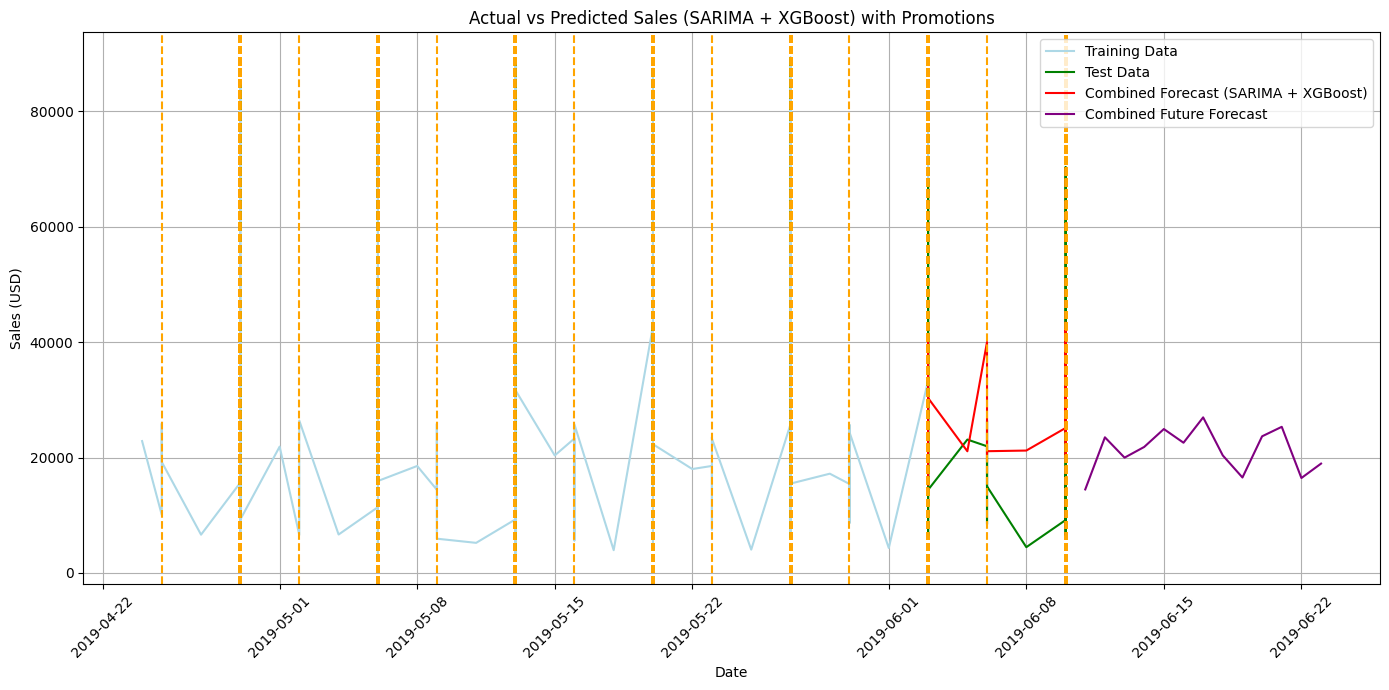

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

# Load your CSV data
file_path = 'merged_sales_promotions_filtered (6).xlsx'
data = pd.read_excel(file_path)

# Convert START_DATE to datetime and set as index
data['START_DATE'] = pd.to_datetime(data['START_DATE'])
data.set_index('START_DATE', inplace=True)

# Sort data by date to ensure the split is correct
data = data.sort_index()

# Take only the first 2000 rows for testing
data = data.iloc[:2000]

# Create a promotion_active column (1 if promotion is active, 0 otherwise)
data['promotion_active'] = np.where(data['PROMOTION_TYPE'].notna(), 1, 0)

# Define the target variable
target = 'NET_SALES_FINAL_USD_AMOUNT'

# Perform an 80-20 train-test split
train_size = int(len(data) * 0.8)
train, test = data[:train_size], data[train_size:]

# Train SARIMA model with promotion as exogenous variable
sarima_model = SARIMAX(train[target], order=(5, 1, 0), seasonal_order=(1, 1, 1, 52), exog=train[['promotion_active']])
sarima_model_fit = sarima_model.fit()

# Make predictions for the test data period, including promotions as exogenous variable
sarima_forecast = sarima_model_fit.get_forecast(steps=len(test), exog=test[['promotion_active']]).predicted_mean

# Calculate residuals
residuals = train[target] - sarima_model_fit.fittedvalues
residuals = np.array(residuals)

# Prepare data for XGBoost, including promotion_active as a feature
train_features = np.arange(len(train)).reshape(-1, 1)
test_features = np.arange(len(train), len(train) + len(test)).reshape(-1, 1)
train_features = np.hstack((train_features, train[['promotion_active']].values))  # Adding promotion_active to features
test_features = np.hstack((test_features, test[['promotion_active']].values))  # Adding promotion_active to features

# Scale features
scaler = StandardScaler()
train_features_scaled = scaler.fit_transform(train_features)
test_features_scaled = scaler.transform(test_features)

# Define and use the XGBRegressor model with default parameters (no GridSearchCV)
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_jobs=1)

# Train the XGBoost model on the residuals
xgb_model.fit(train_features_scaled, residuals.flatten())

# Forecast residuals using the trained XGBoost model
xgb_forecast_residuals = xgb_model.predict(test_features_scaled)

# Combine SARIMA forecast and XGBoost forecast residuals
combined_forecast = sarima_forecast + xgb_forecast_residuals

# Evaluate combined model
combined_mse = mean_squared_error(test[target], combined_forecast)
combined_rmse = np.sqrt(combined_mse)
combined_mae = mean_absolute_error(test[target], combined_forecast)
combined_r2 = r2_score(test[target], combined_forecast)

# Print evaluation metrics
print(f"Combined Model Mean Squared Error: {combined_mse}")
print(f"Combined Model Root Mean Squared Error: {combined_rmse}")
print(f"Combined Model Mean Absolute Error: {combined_mae}")
print(f"Combined Model R^2: {combined_r2}")
# Create a new index for the future forecast (13 future steps)
future_steps = 13
# Assuming no promotions in the future (set to 0 for all future steps)
future_features = np.zeros((future_steps, 1))  # Only one feature: promotion_active

# Forecast future residuals using XGBoost
xgb_future_forecast_residuals = xgb_model.predict(future_features_scaled)

# Forecast future values using SARIMA (future values of promotion_active can be passed if known)
sarima_future_forecast = sarima_model_fit.get_forecast(steps=future_steps, exog=future_features).predicted_mean

# Combine future SARIMA forecast and XGBoost residuals forecast
combined_future_forecast = sarima_future_forecast + xgb_future_forecast_residuals

# Plot actual vs predicted values
plt.figure(figsize=(14, 7))

# Plot training data
plt.plot(train.index, train[target], label='Training Data', color='lightblue')

# Plot test data
plt.plot(test.index, test[target], label='Test Data', color='green')

# Plot combined predictions
plt.plot(test.index, combined_forecast, label='Combined Forecast (SARIMA + XGBoost)', color='red')

# Generate future dates for plotting (assuming daily frequency)
future_dates = pd.date_range(start=test.index[-1], periods=future_steps + 1, freq='D')[1:]

# Plot combined future predictions
plt.plot(future_dates, combined_future_forecast, label='Combined Future Forecast', color='purple', linestyle='solid')

# Mark promotion start points
promotion_starts = data[data['promotion_active'] == 1].index
for promo_start in promotion_starts:
    plt.axvline(x=promo_start, color='orange', linestyle='--')

plt.xlabel('Date')
plt.ylabel('Sales (USD)')
plt.title('Actual vs Predicted Sales (SARIMA + XGBoost) with Promotions')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



Combined Model Mean Squared Error: 273251650.4883719
Combined Model Root Mean Squared Error: 16530.32517793803
Combined Model Mean Absolute Error: 12711.890777018443
Combined Model R^2: -1.073168801014062


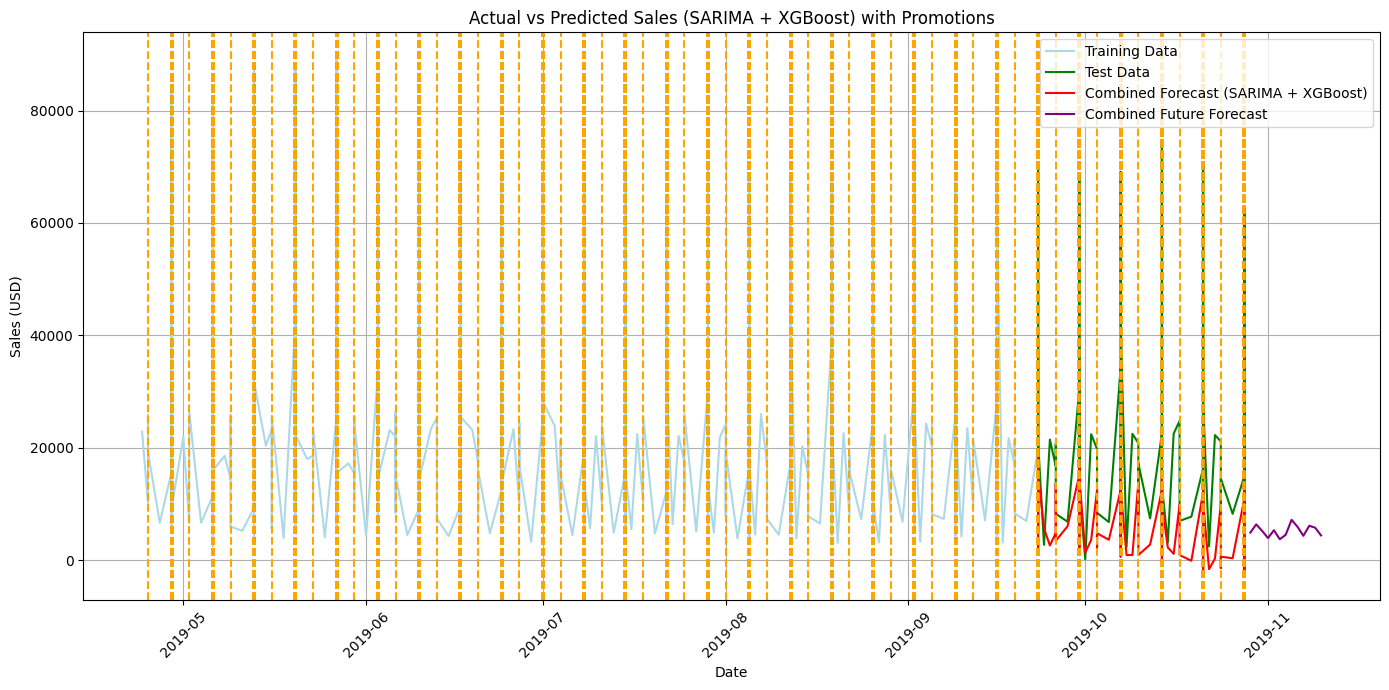

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

# Load your CSV data
file_path = 'merged_sales_promotions_filtered (6).xlsx'
data = pd.read_excel(file_path)

# Convert START_DATE to datetime and set as index
data['START_DATE'] = pd.to_datetime(data['START_DATE'])
data.set_index('START_DATE', inplace=True)

# Sort data by date to ensure the split is correct
data = data.sort_index()

# Take only the first 10,000 rows for testing
data = data.iloc[:8000]

# Create a promotion_active column (1 if promotion is active, 0 otherwise)
data['promotion_active'] = np.where(data['PROMOTION_TYPE'].notna(), 1, 0)

# Define the target variable
target = 'NET_SALES_FINAL_USD_AMOUNT'

# Perform an 80-20 train-test split
train_size = int(len(data) * 0.8)
train, test = data[:train_size], data[train_size:]

# Train SARIMA model with promotion as exogenous variable
sarima_model = SARIMAX(train[target],
                       order=(5, 1, 0),
                       seasonal_order=(1, 1, 1, 52),
                       exog=train[['promotion_active']])
sarima_model_fit = sarima_model.fit()

# Make predictions for the test data period, including promotions as exogenous variable
sarima_forecast = sarima_model_fit.get_forecast(steps=len(test), exog=test[['promotion_active']]).predicted_mean

# Calculate residuals
residuals = train[target] - sarima_model_fit.fittedvalues.values

# Prepare data for XGBoost, including promotion_active as a feature
train_features = np.arange(len(train)).reshape(-1, 1)
test_features = np.arange(len(train), len(train) + len(test)).reshape(-1, 1)
train_features = np.hstack((train_features, train[['promotion_active']].values))
test_features = np.hstack((test_features, test[['promotion_active']].values))

# Scale features
scaler = StandardScaler()
train_features_scaled = scaler.fit_transform(train_features)
test_features_scaled = scaler.transform(test_features)

# Define and use the XGBRegressor model with reasonable hyperparameters
xgb_model = xgb.XGBRegressor(objective='reg:squarederror',
                             n_jobs=1,
                             max_depth=6,
                             learning_rate=0.1,
                             n_estimators=100)
xgb_model.fit(train_features_scaled, residuals)

# Forecast residuals using the trained XGBoost model
xgb_forecast_residuals = xgb_model.predict(test_features_scaled)

# Combine SARIMA forecast and XGBoost forecast residuals
combined_forecast = sarima_forecast + xgb_forecast_residuals

# Evaluate combined model
combined_mse = mean_squared_error(test[target], combined_forecast)
combined_rmse = np.sqrt(combined_mse)
combined_mae = mean_absolute_error(test[target], combined_forecast)
combined_r2 = r2_score(test[target], combined_forecast)

# Print evaluation metrics
print(f"Combined Model Mean Squared Error: {combined_mse}")
print(f"Combined Model Root Mean Squared Error: {combined_rmse}")
print(f"Combined Model Mean Absolute Error: {combined_mae}")
print(f"Combined Model R^2: {combined_r2}")

# Future forecasting
future_steps = 13
future_features = np.zeros((future_steps, 1))  # Assuming no promotions in the future
future_features_scaled = scaler.transform(np.hstack((np.arange(len(train) + len(test),
                                                                len(train) + len(test) + future_steps).reshape(-1, 1),
                                                     future_features)))

# Forecast future residuals using XGBoost
xgb_future_forecast_residuals = xgb_model.predict(future_features_scaled)

# Forecast future values using SARIMA
sarima_future_forecast = sarima_model_fit.get_forecast(steps=future_steps, exog=future_features).predicted_mean

# Combine future SARIMA forecast and XGBoost residuals forecast
combined_future_forecast = sarima_future_forecast + xgb_future_forecast_residuals

# Plot actual vs predicted values
plt.figure(figsize=(14, 7))

# Plot training data
plt.plot(train.index, train[target], label='Training Data', color='lightblue')

# Plot test data
plt.plot(test.index, test[target], label='Test Data', color='green')

# Plot combined predictions
plt.plot(test.index, combined_forecast, label='Combined Forecast (SARIMA + XGBoost)', color='red')

# Generate future dates for plotting (assuming daily frequency)
future_dates = pd.date_range(start=test.index[-1], periods=future_steps + 1, freq='D')[1:]

# Plot combined future predictions
plt.plot(future_dates, combined_future_forecast, label='Combined Future Forecast', color='purple', linestyle='solid')

# Mark visible promotion start points
visible_promotions = data[(data['promotion_active'] == 1) & (data.index >= train.index.min()) & (data.index <= test.index.max())].index
for promo_start in visible_promotions:
    plt.axvline(x=promo_start, color='orange', linestyle='--')

plt.xlabel('Date')
plt.ylabel('Sales (USD)')
plt.title('Actual vs Predicted Sales (SARIMA + XGBoost) with Promotions')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd

# Load the sales data
sales_data = pd.read_csv("sales_store_wise_7.csv")

# Load the store data
store_data = pd.read_csv("store_final.csv")

# Perform the join operation on STORE_NUMBER
store_sale_location = pd.merge(sales_data, store_data, left_on="STORE_NUMBER", right_on="STORE_NUMBER", how="inner")

# Save the merged dataset to a new CSV file
store_sale_location.to_csv("store_sale_location.csv", index=False)

# Display the first few rows of the merged dataset
print(store_sale_location.head())


   STORE_NUMBER OPEN_DATE_x  MONTH_ORDER  START_DATE    END_DATE  \
0             2  09-05-1998          243  29-04-2019  05-05-2019   
1             2  09-05-1998          242  06-05-2019  12-05-2019   
2             2  09-05-1998          241  13-05-2019  19-05-2019   
3             2  09-05-1998          240  20-05-2019  26-05-2019   
4             2  09-05-1998          239  27-05-2019  02-06-2019   

   TRANSACTION_FINAL_COUNT  NET_SALES_FINAL_USD_AMOUNT STORE_NAME  \
0                      897                    15657.59        TX2   
1                      918                    15291.24        TX2   
2                      954                    16014.65        TX2   
3                      894                    14951.45        TX2   
4                      855                    15157.71        TX2   

  STORE_TYPE_NAME OPEN_DATE_y  ... REGION_ID REGION_NAME STORE_LIVE_DATE  \
0       Franchise  09-05-1998  ...       1.0   Southwest      09-05-1998   
1       Franchise  09-05

In [ ]:
!pip install statsmodels

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 71.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.9/232.9 kB 18.4 MB/s eta 0:00:00


In [ ]:
!pip install xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 223.6/223.6 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.4/201.4 MB 4.2 MB/s eta 0:00:00


In [ ]:
import pandas as pd

# Load the sales data
sales_data = pd.read_csv("sales_store_wise_7.csv")

# Load the store data
store_data = pd.read_csv("store_final.csv")

# Perform the join operation on STORE_NUMBER
store_sale_location = pd.merge(sales_data, store_data, on="STORE_NUMBER", how="inner")

# Filter only the rows where state_name is Texas, Nevada, New Hampshire, or Iowa
filtered_states = ["Texas", "Nevada", "New Hampshire", "Iowa"]
filtered_data = store_sale_location[store_sale_location["STATE_NAME"].isin(filtered_states)]

# Save the filtered dataset to a new CSV file
filtered_data.to_csv("filtered_store_sale_location.csv", index=False)

# Display the first few rows of the filtered dataset
print(filtered_data.head())


   STORE_NUMBER OPEN_DATE_x  MONTH_ORDER  START_DATE    END_DATE  \
0             2  09-05-1998          243  29-04-2019  05-05-2019   
1             2  09-05-1998          242  06-05-2019  12-05-2019   
2             2  09-05-1998          241  13-05-2019  19-05-2019   
3             2  09-05-1998          240  20-05-2019  26-05-2019   
4             2  09-05-1998          239  27-05-2019  02-06-2019   

   TRANSACTION_FINAL_COUNT  NET_SALES_FINAL_USD_AMOUNT STORE_NAME  \
0                      897                    15657.59        TX2   
1                      918                    15291.24        TX2   
2                      954                    16014.65        TX2   
3                      894                    14951.45        TX2   
4                      855                    15157.71        TX2   

  STORE_TYPE_NAME OPEN_DATE_y  ... REGION_ID REGION_NAME STORE_LIVE_DATE  \
0       Franchise  09-05-1998  ...       1.0   Southwest      09-05-1998   
1       Franchise  09-05

In [ ]:
!pip install scikit-learn==1.3.0 xgboost==2.0.3


Mean Squared Error (MSE): 93256535439.97
Root Mean Squared Error (RMSE): 305379.33
Mean Absolute Error (MAE): 253214.55
R-squared (R^2): -0.0233


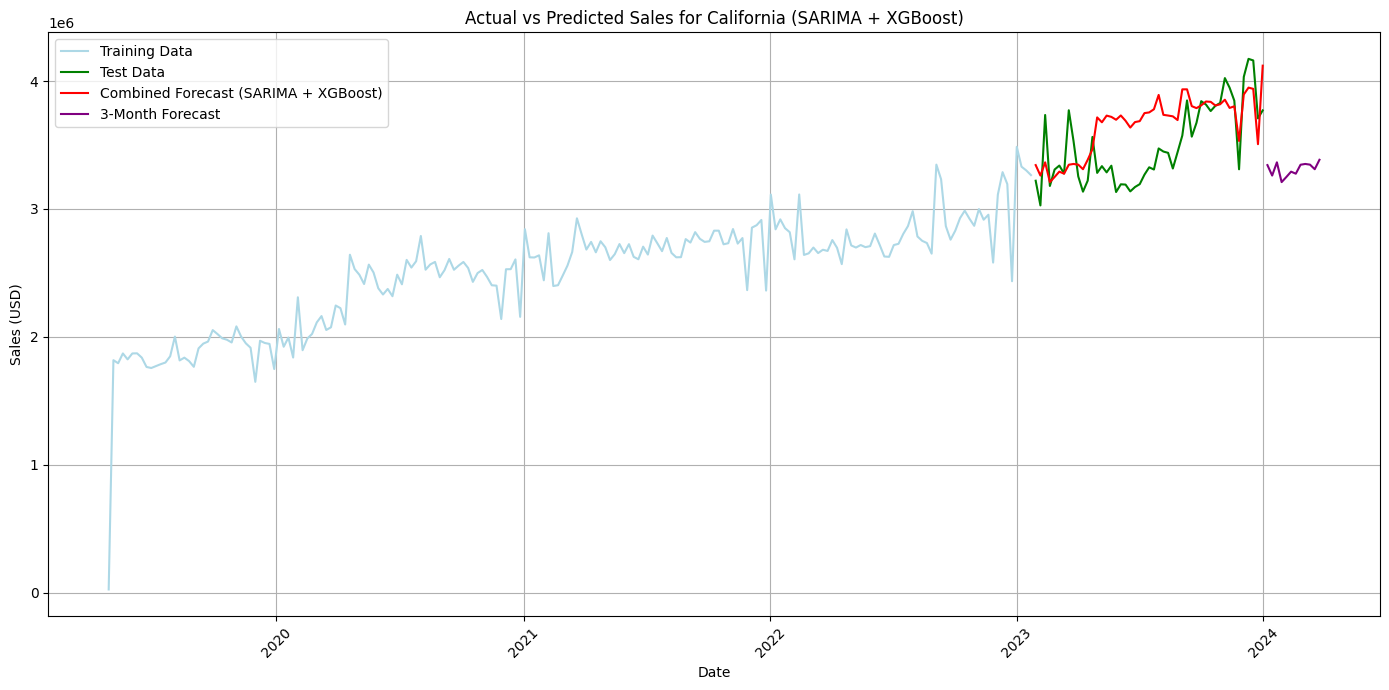

Mean Squared Error (MSE): 10288322.74
Root Mean Squared Error (RMSE): 3207.54
Mean Absolute Error (MAE): 2637.88
R-squared (R^2): 0.4972


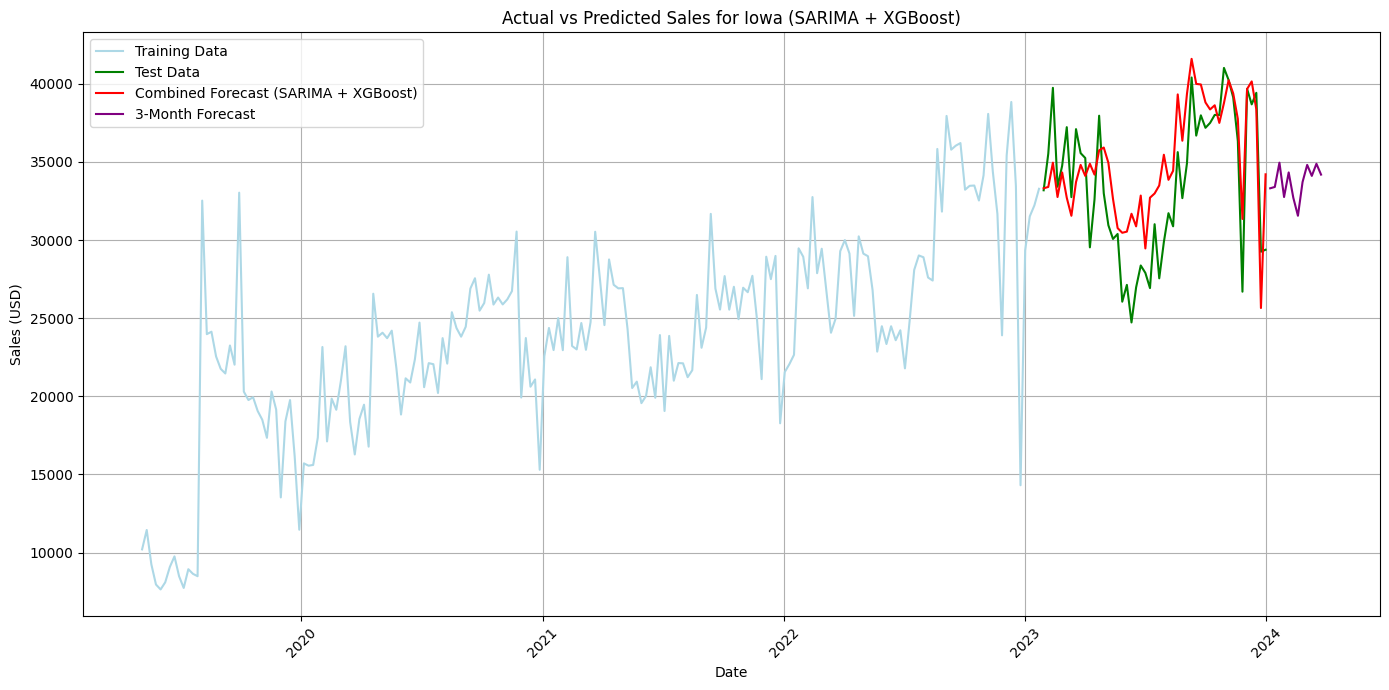

Mean Squared Error (MSE): 140103651.78
Root Mean Squared Error (RMSE): 11836.54
Mean Absolute Error (MAE): 8726.34
R-squared (R^2): -0.5960


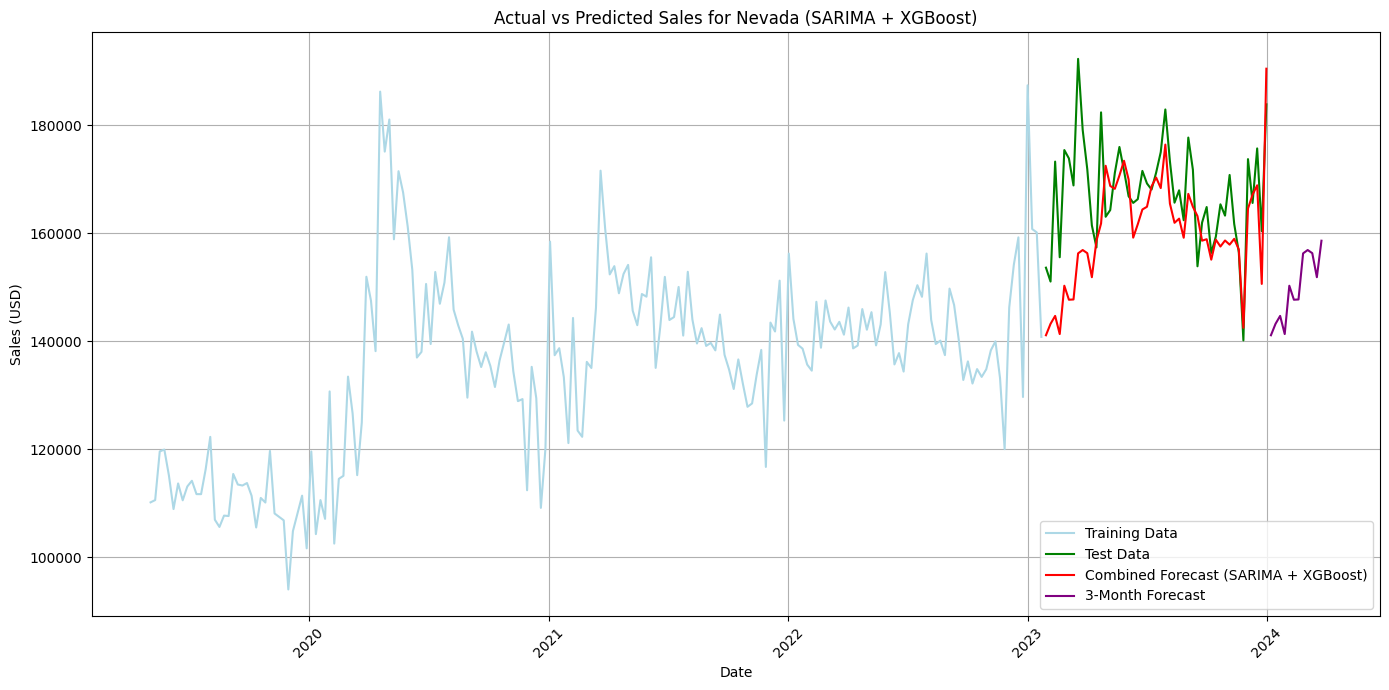

Mean Squared Error (MSE): 5134411.20
Root Mean Squared Error (RMSE): 2265.92
Mean Absolute Error (MAE): 1903.07
R-squared (R^2): 0.5173


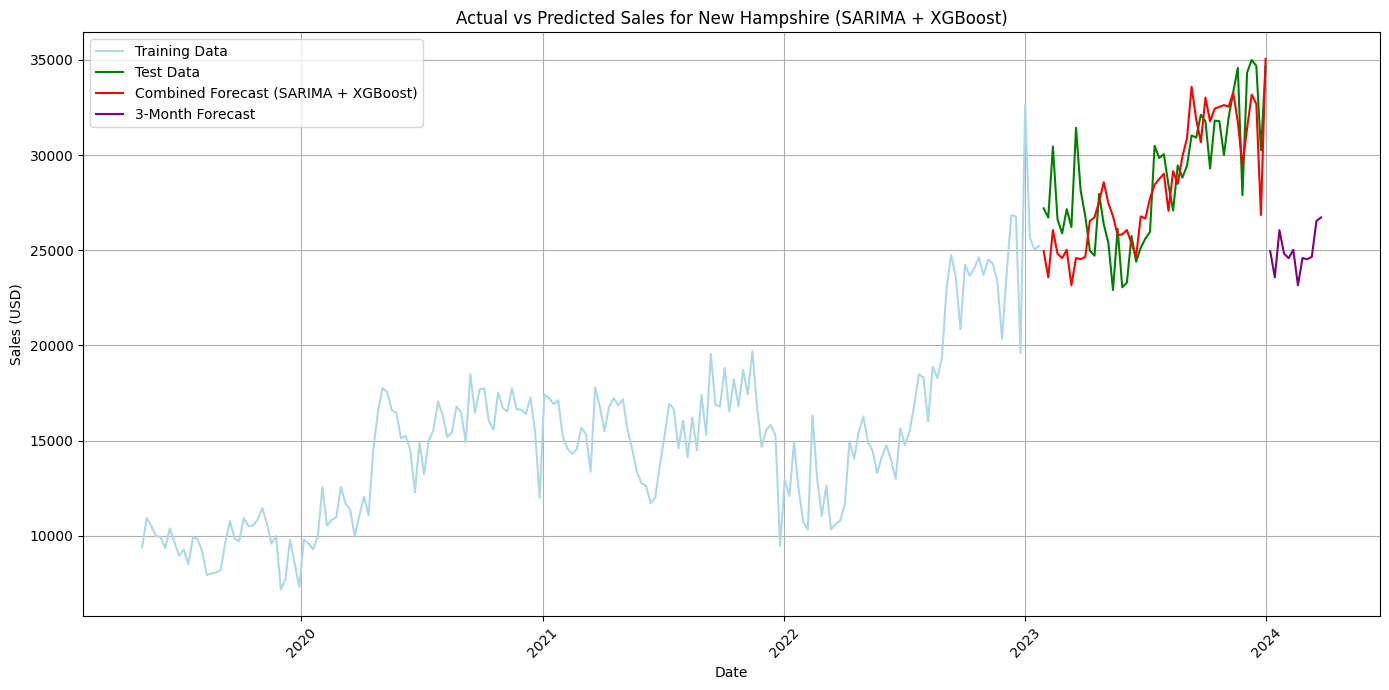

Mean Squared Error (MSE): 198162288921.83
Root Mean Squared Error (RMSE): 445154.23
Mean Absolute Error (MAE): 399076.78
R-squared (R^2): -3.1471


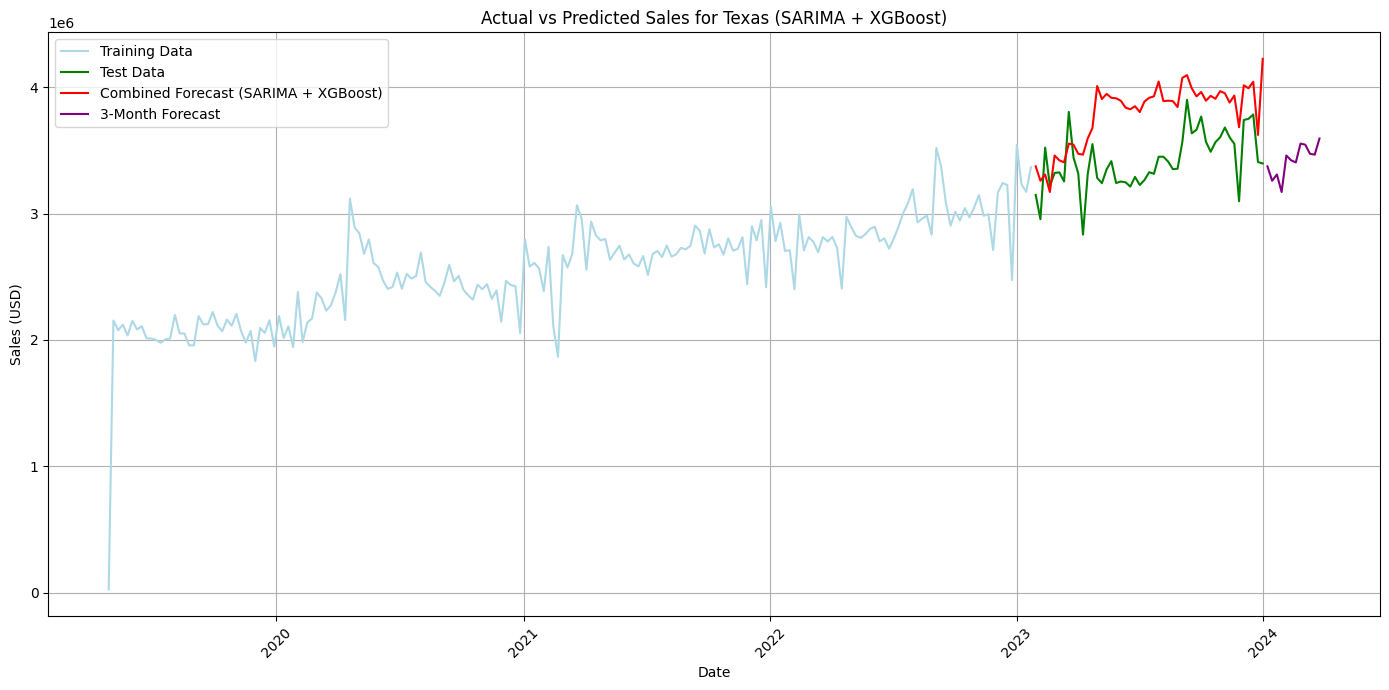

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

# Load the merged dataset
file_path = 'store_sale_location.csv'
data = pd.read_csv(file_path)

# Filter dataset for only Texas, Nevada, New Hampshire, and Iowa
target_states = ["California","Texas","Iowa","New Hampshire","Nevada"]
data = data[data['STATE_NAME'].isin(target_states)]

# Convert START_DATE to datetime and set as index
data['START_DATE'] = pd.to_datetime(data['START_DATE'])
data.set_index('START_DATE', inplace=True)

# Sort data by date to ensure the split is correct
data = data.sort_index()

# Define the target variable
target = 'NET_SALES_FINAL_USD_AMOUNT'

# Perform forecasting for each unique STATE_NAME
state_forecasts = {}
future_steps = 12  # Forecasting next 3 months (assuming weekly data)

for state, state_data in data.groupby('STATE_NAME'):
    # Aggregate data by week for each state
    state_data = state_data.resample('W').sum()

    # Perform an 80-20 train-test split
    train_size = int(len(state_data) * 0.8)
    train, test = state_data[:train_size], state_data[train_size:]

    # Train SARIMA model
    sarima_model = SARIMAX(train[target], order=(5, 1, 0), seasonal_order=(1, 1, 1, 52))
    sarima_model_fit = sarima_model.fit()

    # Make predictions for the test data period
    sarima_forecast = sarima_model_fit.get_forecast(steps=len(test)).predicted_mean

    # Calculate residuals
    residuals = train[target] - sarima_model_fit.fittedvalues

    # Prepare data for XGBoost
    train_features = np.arange(len(train)).reshape(-1, 1)
    test_features = np.arange(len(train), len(train) + len(test)).reshape(-1, 1)

    # Scale features
    scaler = StandardScaler()
    train_features_scaled = scaler.fit_transform(train_features)
    test_features_scaled = scaler.transform(test_features)

    # Hyperparameter tuning for XGBoost using GridSearchCV
    param_grid = {
        'n_estimators': [100, 200],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.1, 0.2],
        'subsample': [0.8, 1.0]
    }

    xgb_model = xgb.XGBRegressor(objective='reg:squarederror')
    tscv = TimeSeriesSplit(n_splits=5)
    grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=tscv, scoring='neg_mean_squared_error')
    grid_search.fit(train_features_scaled, residuals)


    # Best XGBoost model
    best_xgb_model = grid_search.best_estimator_

    # Forecast residuals using the best XGBoost model
    xgb_forecast_residuals = best_xgb_model.predict(test_features_scaled)

    # Combine SARIMA forecast and XGBoost forecast residuals
    combined_forecast = sarima_forecast + xgb_forecast_residuals
    # Calculate accuracy metrics
    mse = mean_squared_error(test[target], combined_forecast)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(test[target], combined_forecast)
    r2 = r2_score(test[target], combined_forecast)

    # Print results
    print(f"Mean Squared Error (MSE): {mse:.2f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
    print(f"Mean Absolute Error (MAE): {mae:.2f}")
    print(f"R-squared (R^2): {r2:.4f}")

    # Create future forecasting
    future_features = np.arange(len(train) + len(test), len(train) + len(test) + future_steps).reshape(-1, 1)
    future_features_scaled = scaler.transform(future_features)
    future_dates = pd.date_range(start=test.index[-1] + pd.DateOffset(weeks=1), periods=future_steps, freq='W')

    # Forecast future residuals using XGBoost
    xgb_future_forecast_residuals = best_xgb_model.predict(future_features_scaled)

    # Forecast future values using SARIMA
    sarima_future_forecast = sarima_model_fit.get_forecast(steps=future_steps).predicted_mean

    # Combine future SARIMA forecast and XGBoost residuals forecast
    combined_future_forecast = sarima_future_forecast + xgb_future_forecast_residuals

    # Store forecast results
    state_forecasts[state] = combined_future_forecast

    # Plot results
    plt.figure(figsize=(14, 7))
    plt.plot(train.index, train[target], label='Training Data', color='lightblue')
    plt.plot(test.index, test[target], label='Test Data', color='green')
    plt.plot(test.index, combined_forecast, label='Combined Forecast (SARIMA + XGBoost)', color='red')
    plt.plot(future_dates, combined_future_forecast, label='3-Month Forecast', color='purple', linestyle='solid')
    plt.xlabel('Date')
    plt.ylabel('Sales (USD)')
    plt.title(f'Actual vs Predicted Sales for {state} (SARIMA + XGBoost)')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Save forecast results
df_forecasts = pd.DataFrame.from_dict(state_forecasts, orient='index').transpose()
df_forecasts.to_csv('state_forecasts.csv', index=False)